# Leverage gemini to improve the skeleton quality

The skeletons we get are usually jagged and noisy.

This is the root of many evils in our floorplan detection pipeline.

So in this experiment, we leverage Gemini to cleanup or even make the skeleton.

In [1]:
import io, asyncio
from pathlib import Path
from dotenv import load_dotenv
from pydantic_ai import Agent
from pydantic_ai import BinaryImage
import numpy as np
from skimage.morphology import skeletonize
from PIL import Image
import cv2
from typing import Literal
from matplotlib import pyplot as plt
from loguru import logger

load_dotenv()
MODEL_NAME = "gemini-3-pro-image-preview"

## Cleanup of our existing skeleton 

In [2]:
async def clean_up_skeleton(input_image_bytes: bytes, path: Path):
    agent = Agent(
        name="SkeletonizingAgent",
        model=MODEL_NAME,
        output_type=BinaryImage,
        instructions="""You are a computer vision and floorplans specialist. The input is a binary raster image representing the skeleton of a wall network: white pixels indicate the skeleton,
        black is background.
        The skeleton is currently jagged, misaligned, and may contain forks or small artifacts.

    **Your task:**  
    Generate a cleaned, high-fidelity version of the skeleton with the following properties:

    - **Straighten lines:** Replace jagged or wavy segments with straight lines where appropriate.
    - **Align and snap:** Align walls to be parallel or perpendicular where possible, and snap angles to standard values (e.g., 90°, 45°).
    - **Maintain connectivity:** Ensure all original connections between segments are preserved, even if you remove or adjust parts.
    - **Suppress forks:** Remove any Y-shaped junctions, replacing them with T-junctions to simplify the network.
    - **Remove artifacts:** Eliminate small to moderate bumps, spurs, or noise, replacing them with straight segments or removing them entirely when appropriate.
    - **Preserve 1-pixel width:** The output skeleton must remain a single-pixel wide everywhere.
    - **Do not invent or remove walls:** Only modify the geometry of the existing network; do not add or delete any wall segments.
    - **Enhance junction clarity:** Make all junctions clear and unambiguous to facilitate downstream detection.
    - **Avoid arcs and curves:** All wall segments should be straight lines; do not introduce any curved segments.

    **Output:**  
    A binary raster image of the cleaned skeleton, with all the above properties enforced. The output should closely match the topology and layout of the input,
    but with improved geometric regularity and clarity.""",
    )
    image_bytes = await agent.run(
        user_prompt=[BinaryImage(data=input_image_bytes, media_type="image/png")]
    )
    gemini_img = np.array(
        Image.open(io.BytesIO(image_bytes.output.data)).convert("L"), dtype=np.uint8
    )

    # threshold it to make it binary, using Otsu's method
    _, gemini_img = cv2.threshold(gemini_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skeleton = skeletonize(gemini_img, method="lee")

    skeleton_img = (skeleton * 255).astype(np.uint8)
    Image.fromarray(skeleton_img).save(path)
    logger.info(f"Saved skeletonized image to {path}")
    return path

In [3]:
def create_side_by_side_viz(
    original_path: Path, cleaned_path: Path, show_diff: bool = False
) -> None:
    _, axes = plt.subplots(1, 3 if show_diff else 2, figsize=(20, 8))
    original_img = Image.open(original_path).convert("L")
    cleaned_img = Image.open(cleaned_path).convert("L")
    if cleaned_img.size != original_img.size:
        cleaned_img = cleaned_img.resize(original_img.size, resample=Image.NEAREST)

    original_arr = np.array(original_img, dtype=np.uint8)
    cleaned_arr = np.array(cleaned_img, dtype=np.uint8)
    if show_diff:
        diff_arr = cv2.absdiff(original_arr, cleaned_arr)

    axes[0].imshow(original_img, cmap="gray")
    axes[0].set_title("Original Skeleton")
    axes[0].axis("off")
    axes[1].imshow(cleaned_img, cmap="gray")
    axes[1].set_title("Cleaned Skeleton")
    axes[1].axis("off")
    if show_diff:
        axes[2].imshow(diff_arr, cmap="gray")
        axes[2].set_title("Diff")
        axes[2].axis("off")
    plt.tight_layout()

In [4]:
async def batch_clean_skeletons(n_samples: int = 17):
    input_image_paths = [
        f
        for f in Path()
        .cwd()
        .glob("wall_skeleton_*.png")  # the debug images produced in full_walls_detection.py
        if "cleaned" not in f.stem
    ][:n_samples]
    output_image_paths = [
        (input_image_path.parent / f"{input_image_path.stem}_cleaned{input_image_path.suffix}")
        for input_image_path in input_image_paths
    ]

    tasks = []
    for input_image_path, output_image_path in zip(
        input_image_paths, output_image_paths, strict=True
    ):
        with open(input_image_path, "rb") as f:
            input_image_bytes = f.read()
        tasks.append(clean_up_skeleton(input_image_bytes, output_image_path))

    cleaned_paths = await asyncio.gather(*tasks)

    for input_image_path, cleaned_path in zip(input_image_paths, cleaned_paths, strict=True):
        create_side_by_side_viz(input_image_path, cleaned_path)

2026-01-29 17:37:14.509 | INFO     | __main__:clean_up_skeleton:41 - Saved skeletonized image to /Users/clementlelievre/dev/rayon/apps/ai-backend/models/floorplan_detection/experiments/wall_skeleton_1769701681_cleaned.png
2026-01-29 17:37:15.070 | INFO     | __main__:clean_up_skeleton:41 - Saved skeletonized image to /Users/clementlelievre/dev/rayon/apps/ai-backend/models/floorplan_detection/experiments/wall_skeleton_1769698843_cleaned.png
2026-01-29 17:37:15.608 | INFO     | __main__:clean_up_skeleton:41 - Saved skeletonized image to /Users/clementlelievre/dev/rayon/apps/ai-backend/models/floorplan_detection/experiments/wall_skeleton_1769698855_cleaned.png
2026-01-29 17:37:16.057 | INFO     | __main__:clean_up_skeleton:41 - Saved skeletonized image to /Users/clementlelievre/dev/rayon/apps/ai-backend/models/floorplan_detection/experiments/wall_skeleton_1769701680_cleaned.png
2026-01-29 17:37:16.601 | INFO     | __main__:clean_up_skeleton:41 - Saved skeletonized image to /Users/clementl

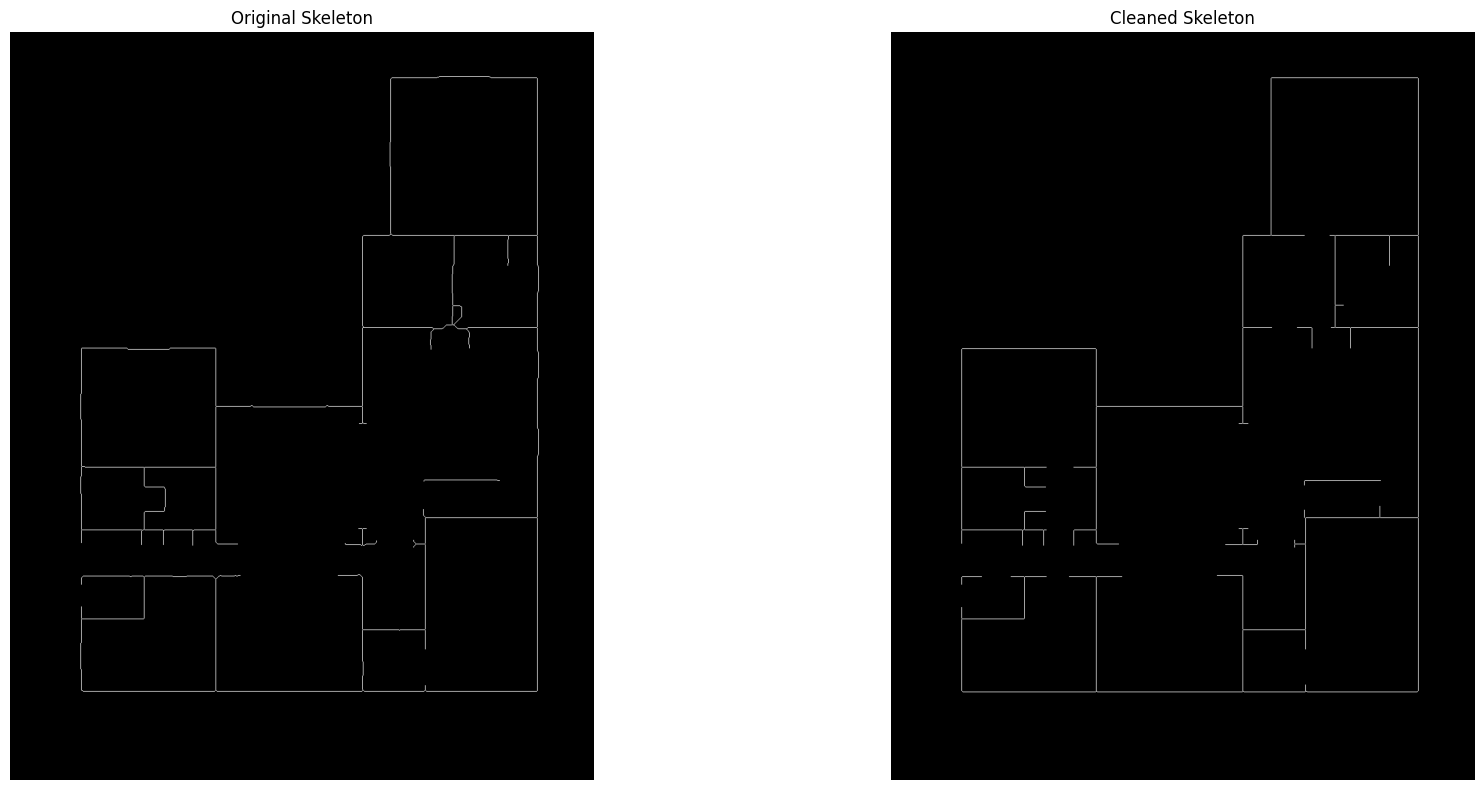

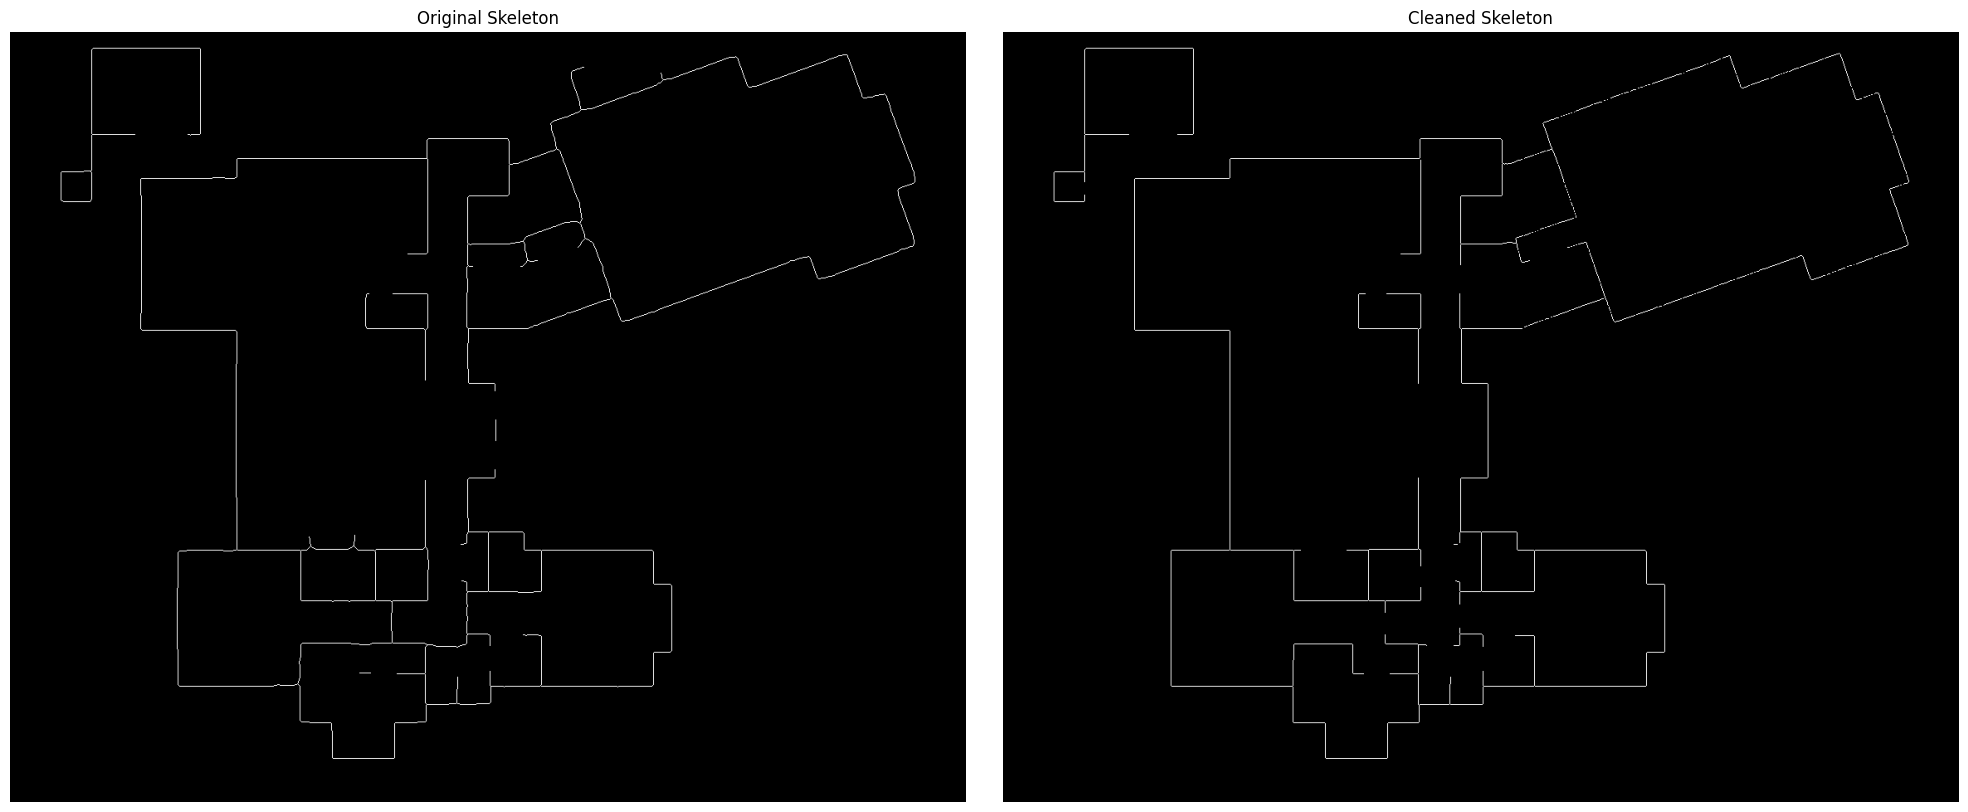

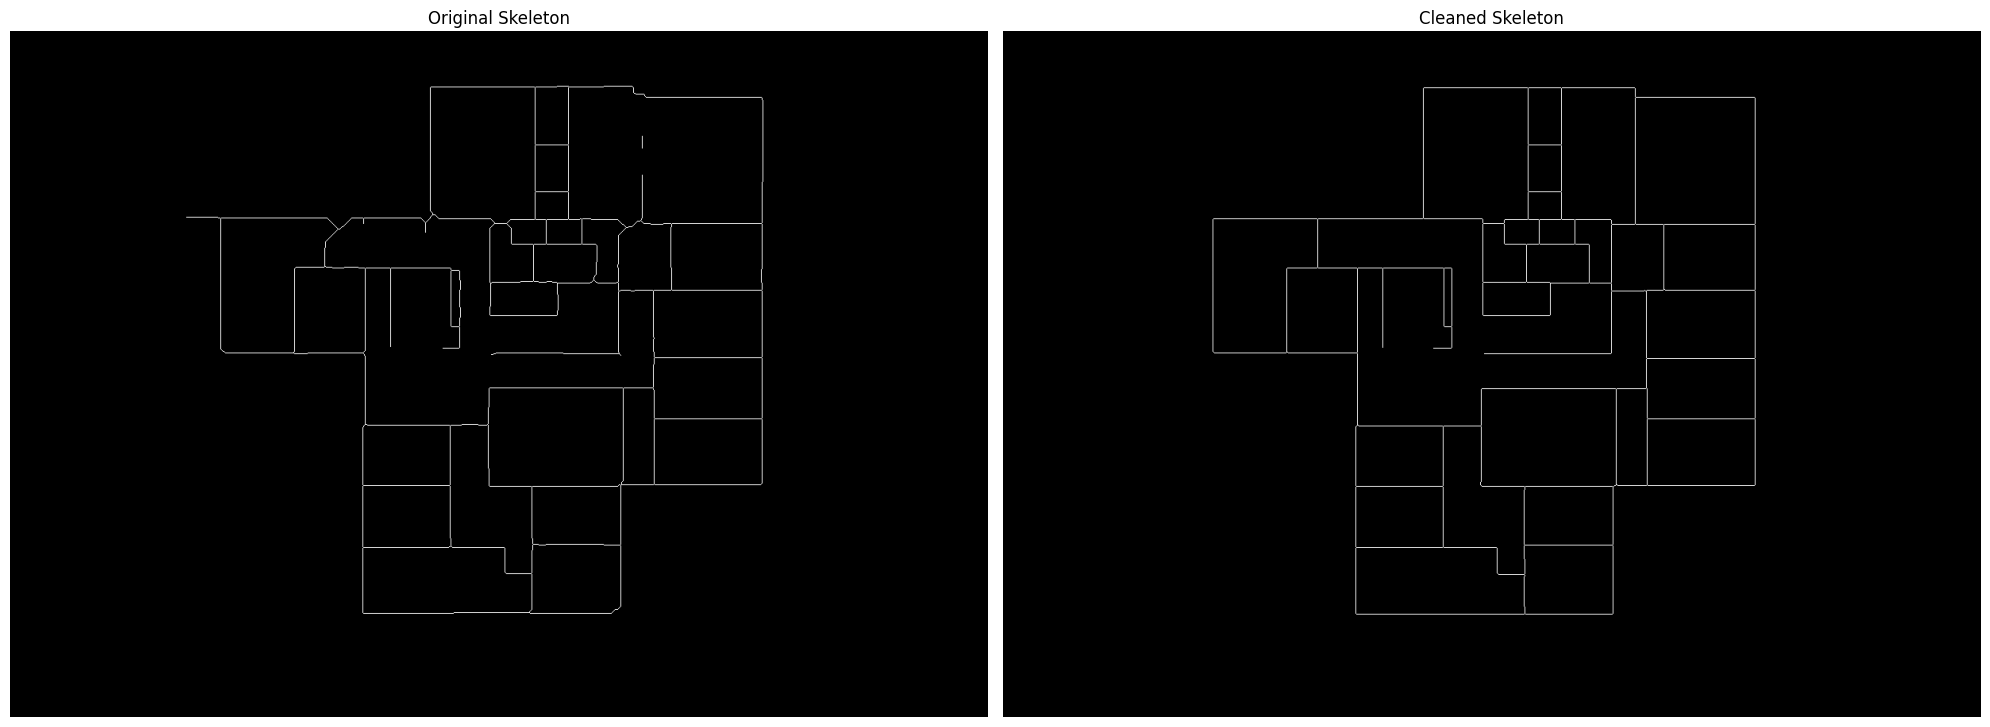

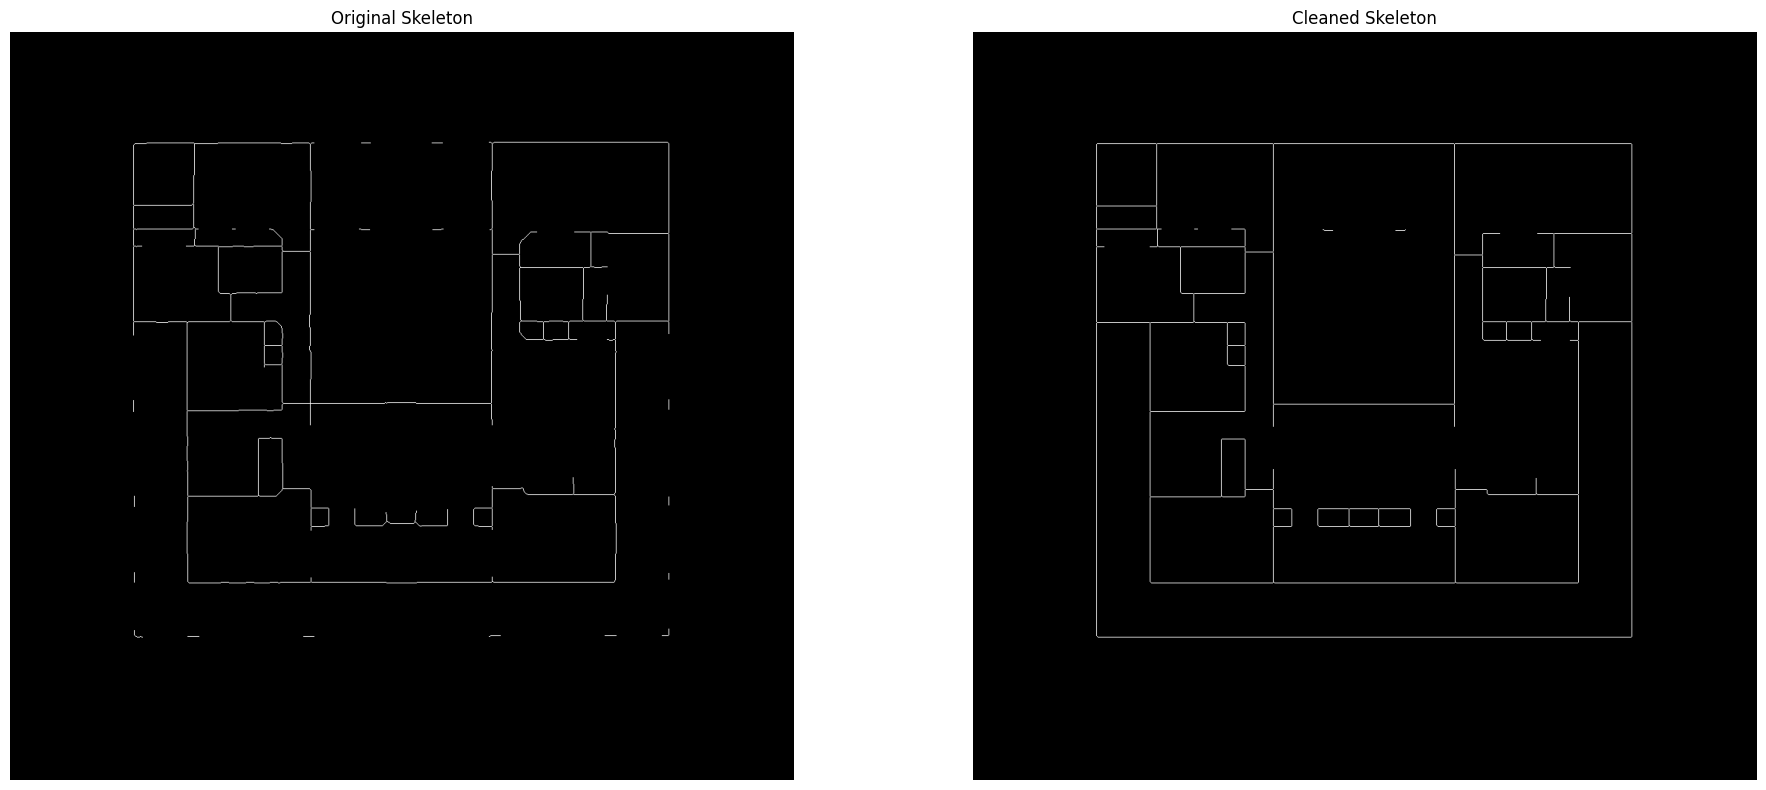

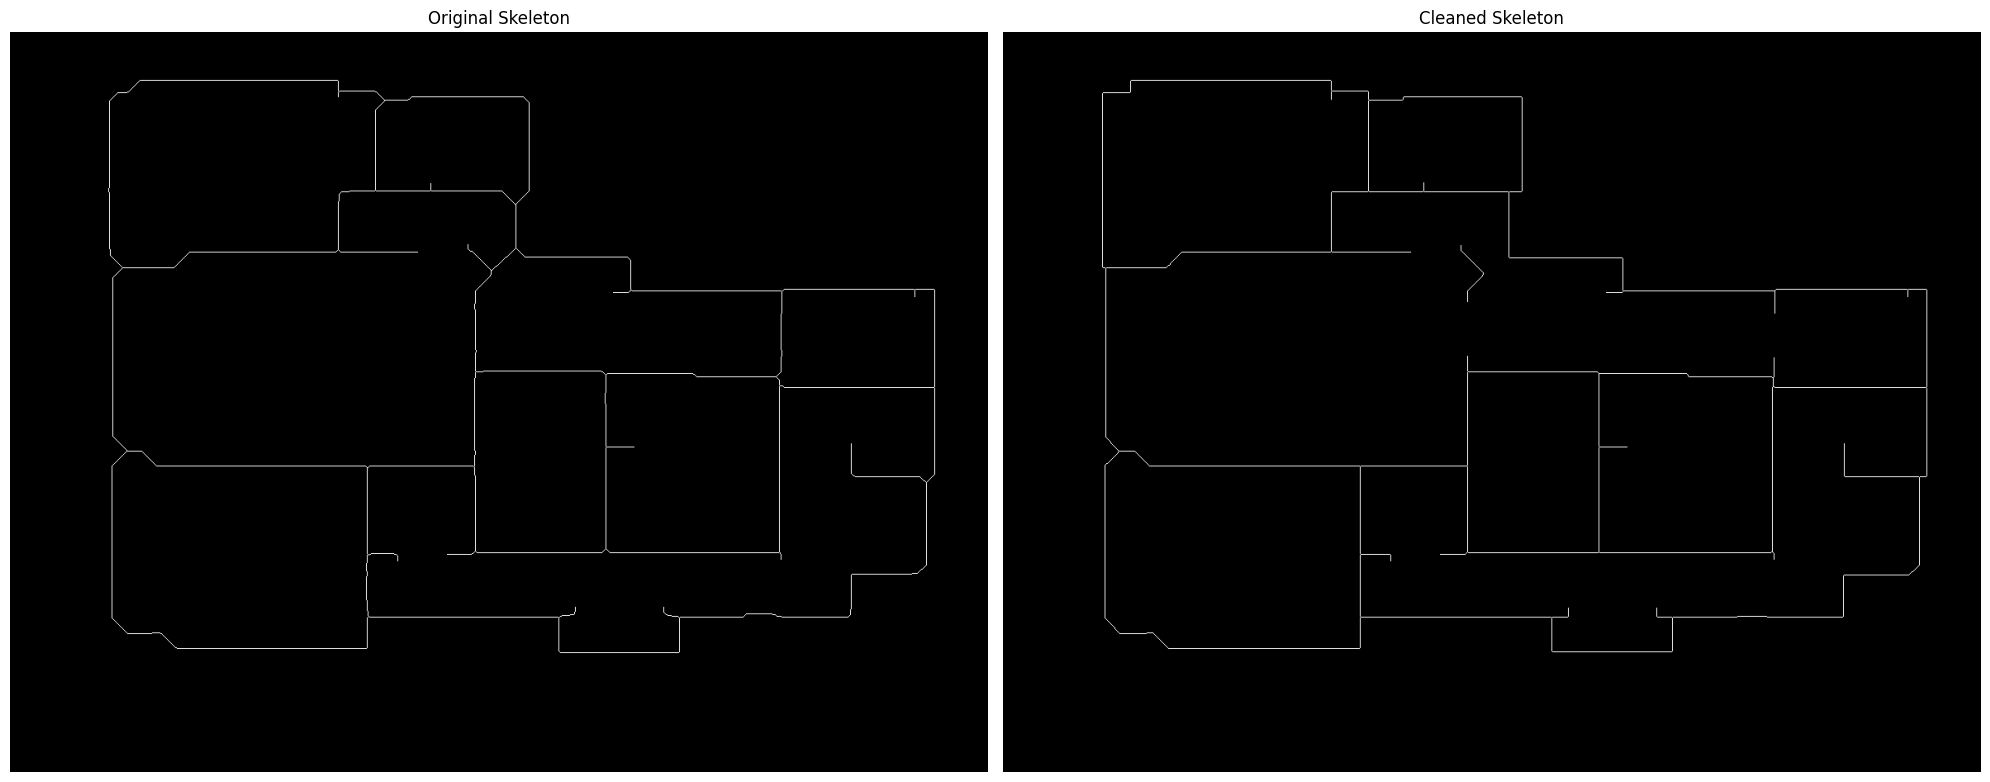

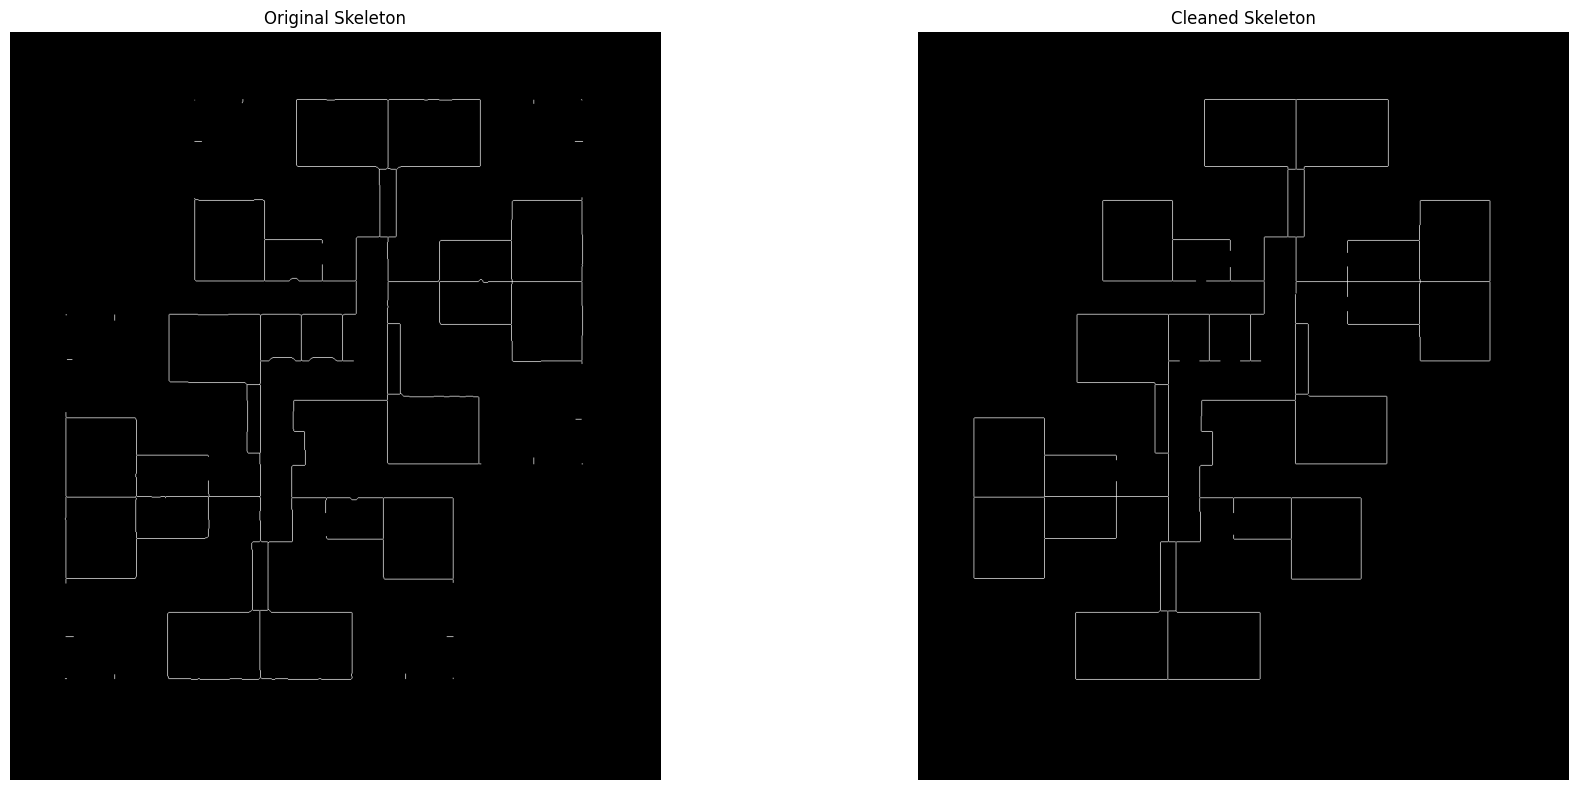

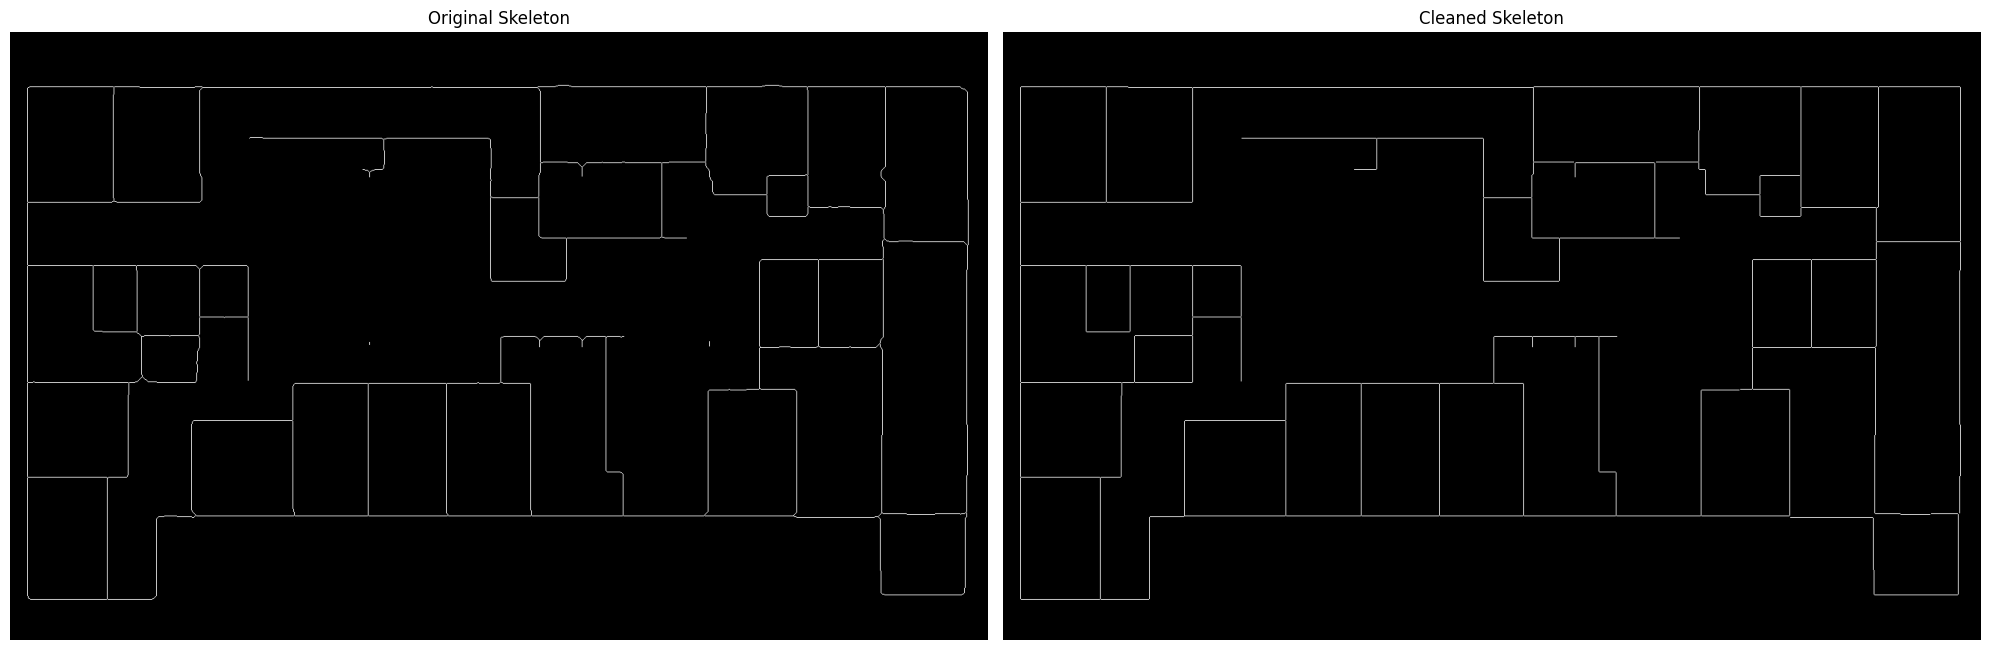

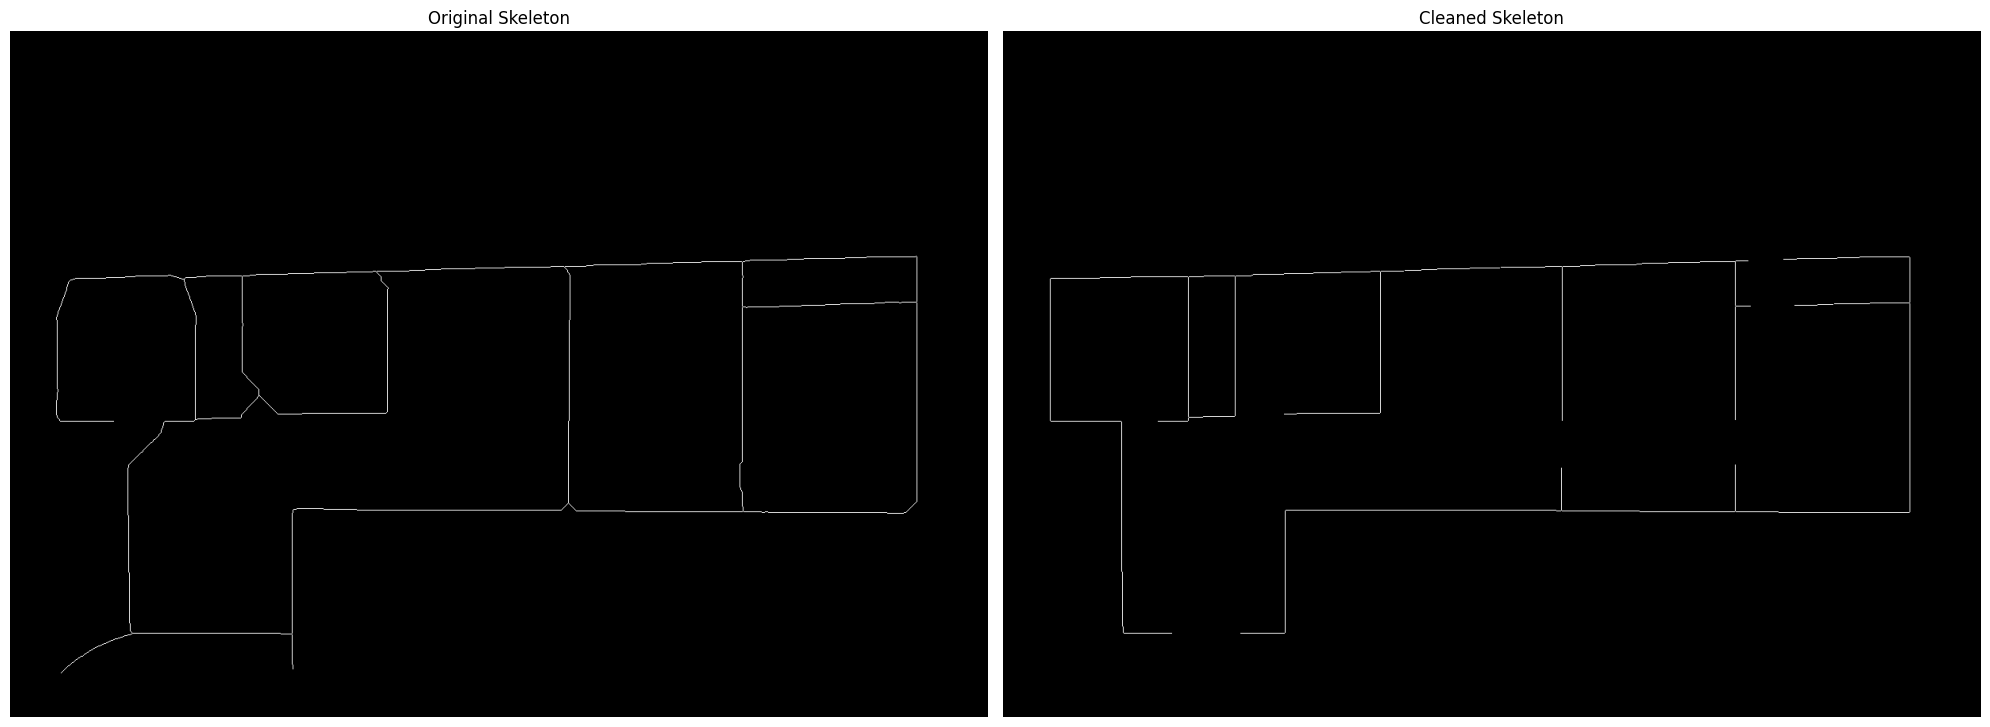

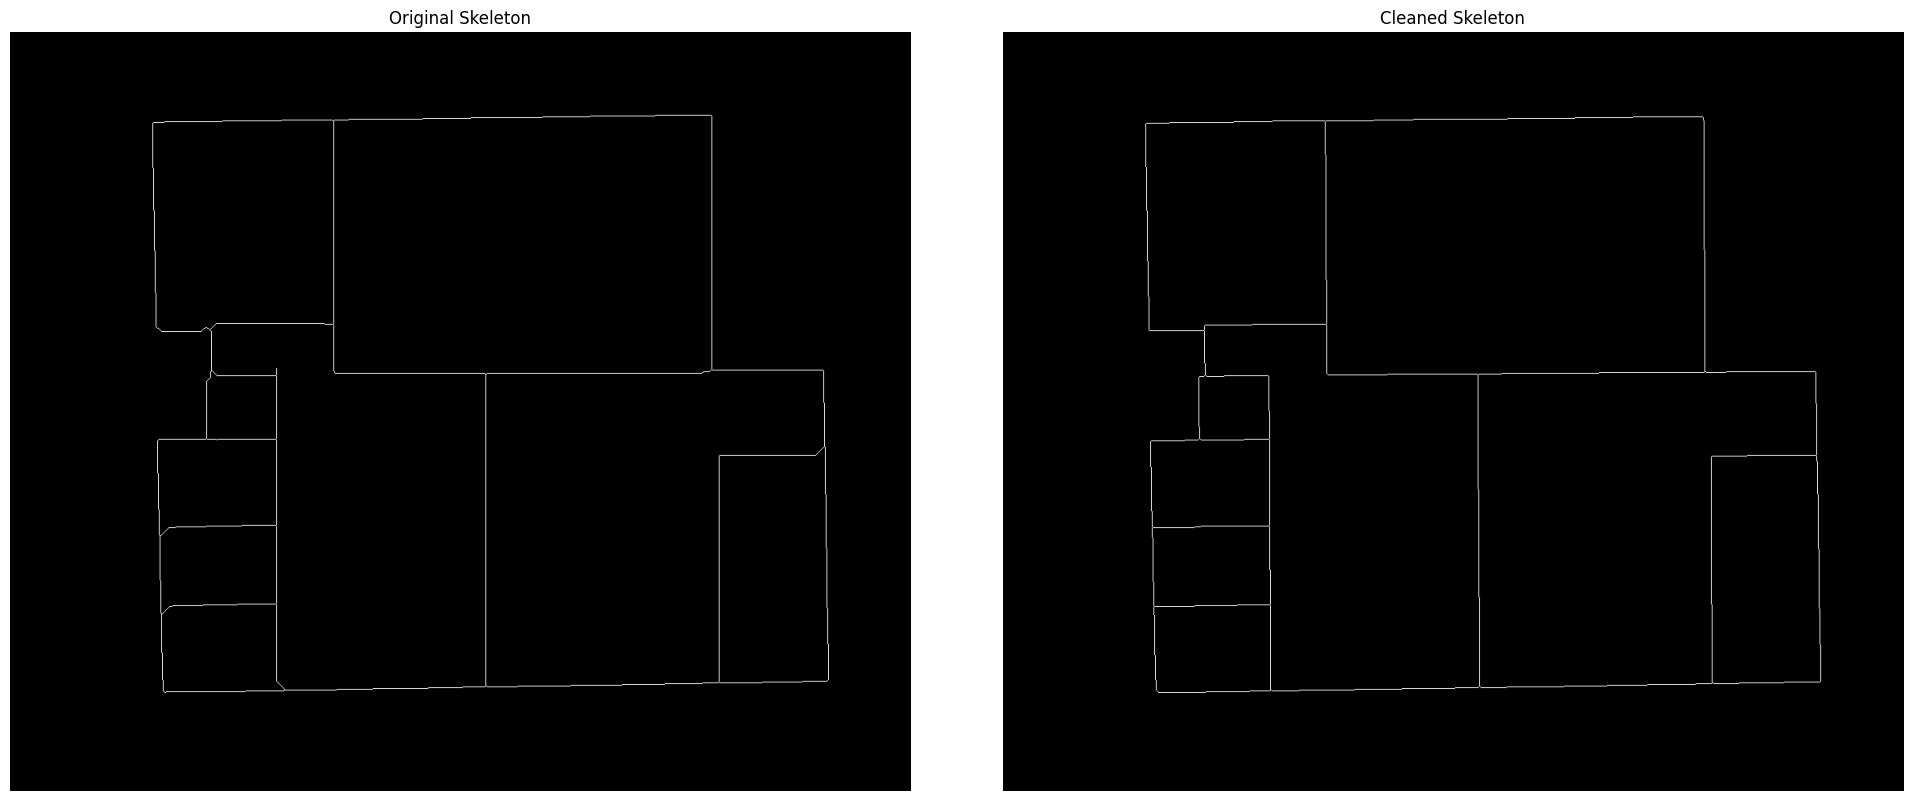

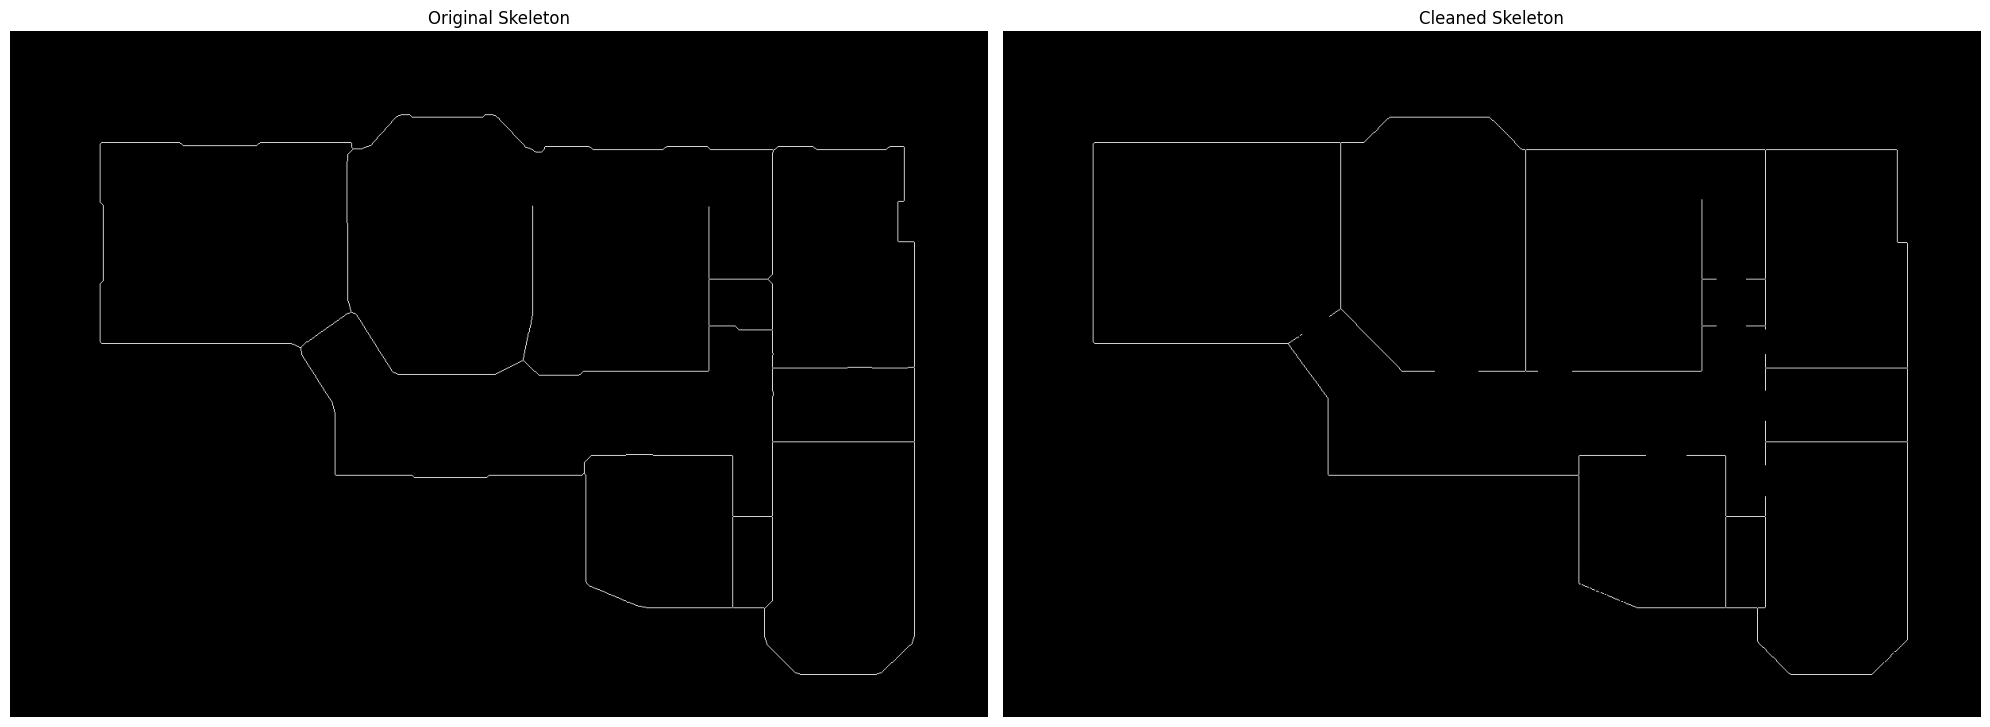

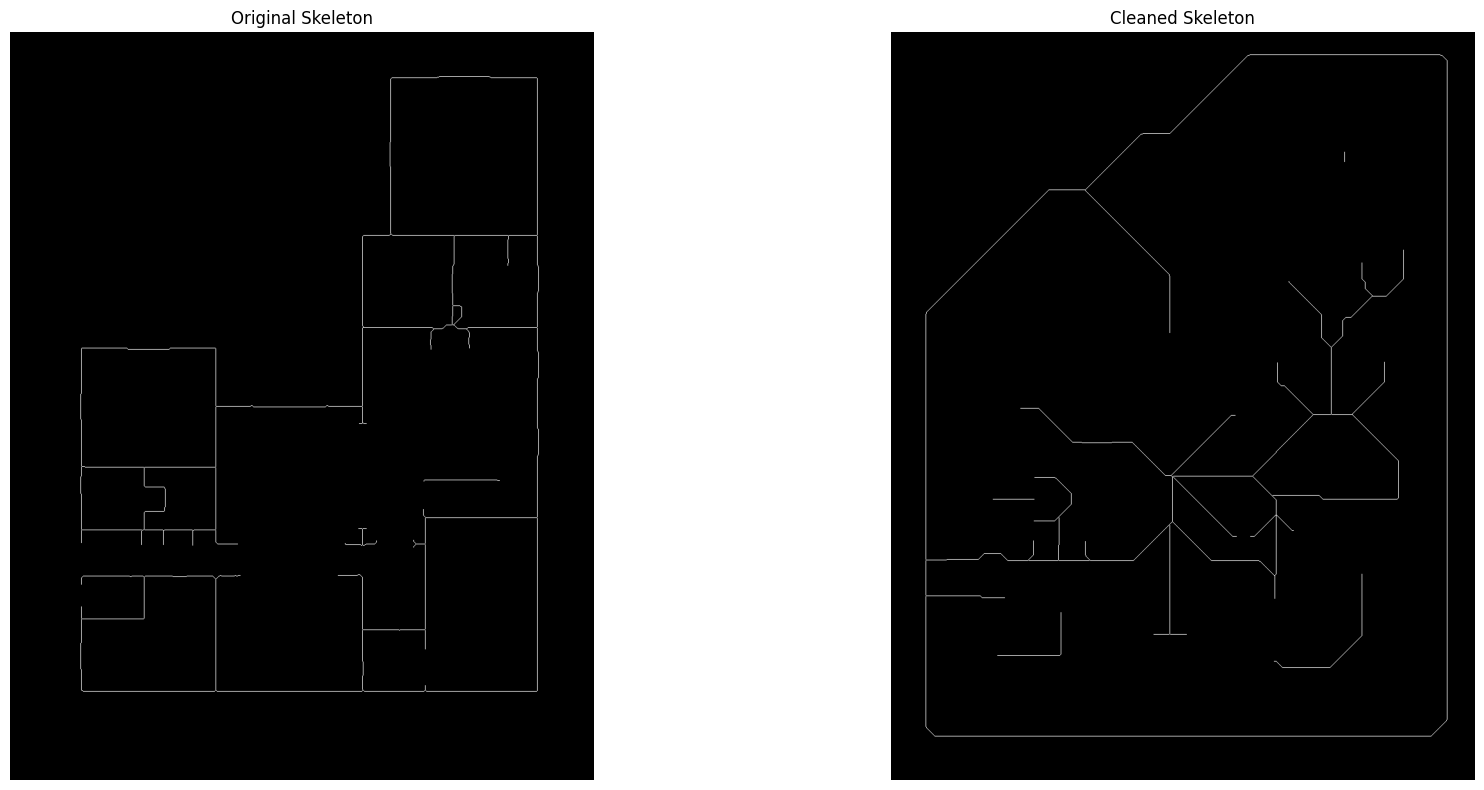

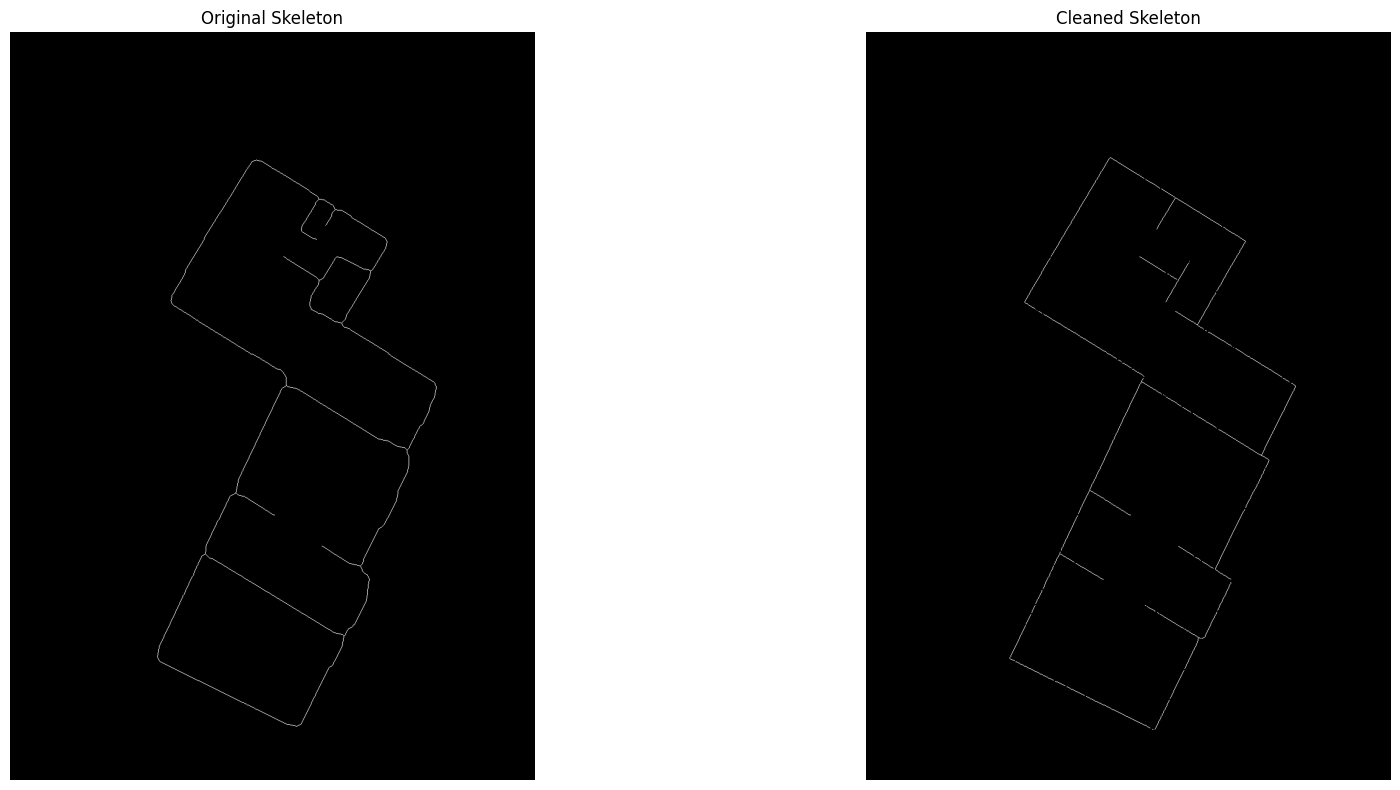

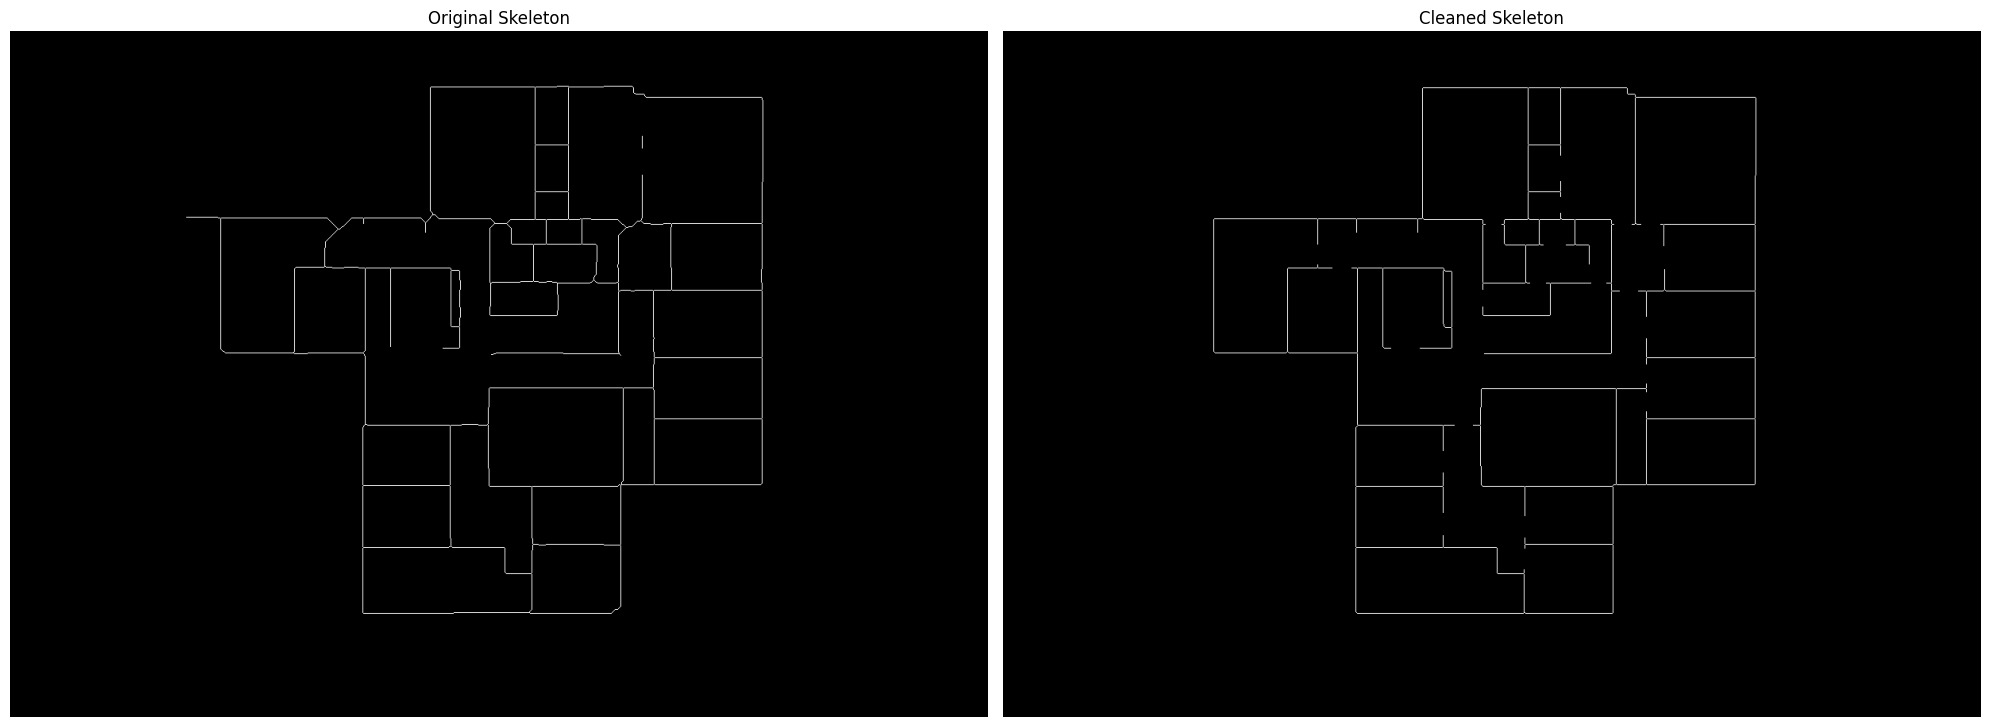

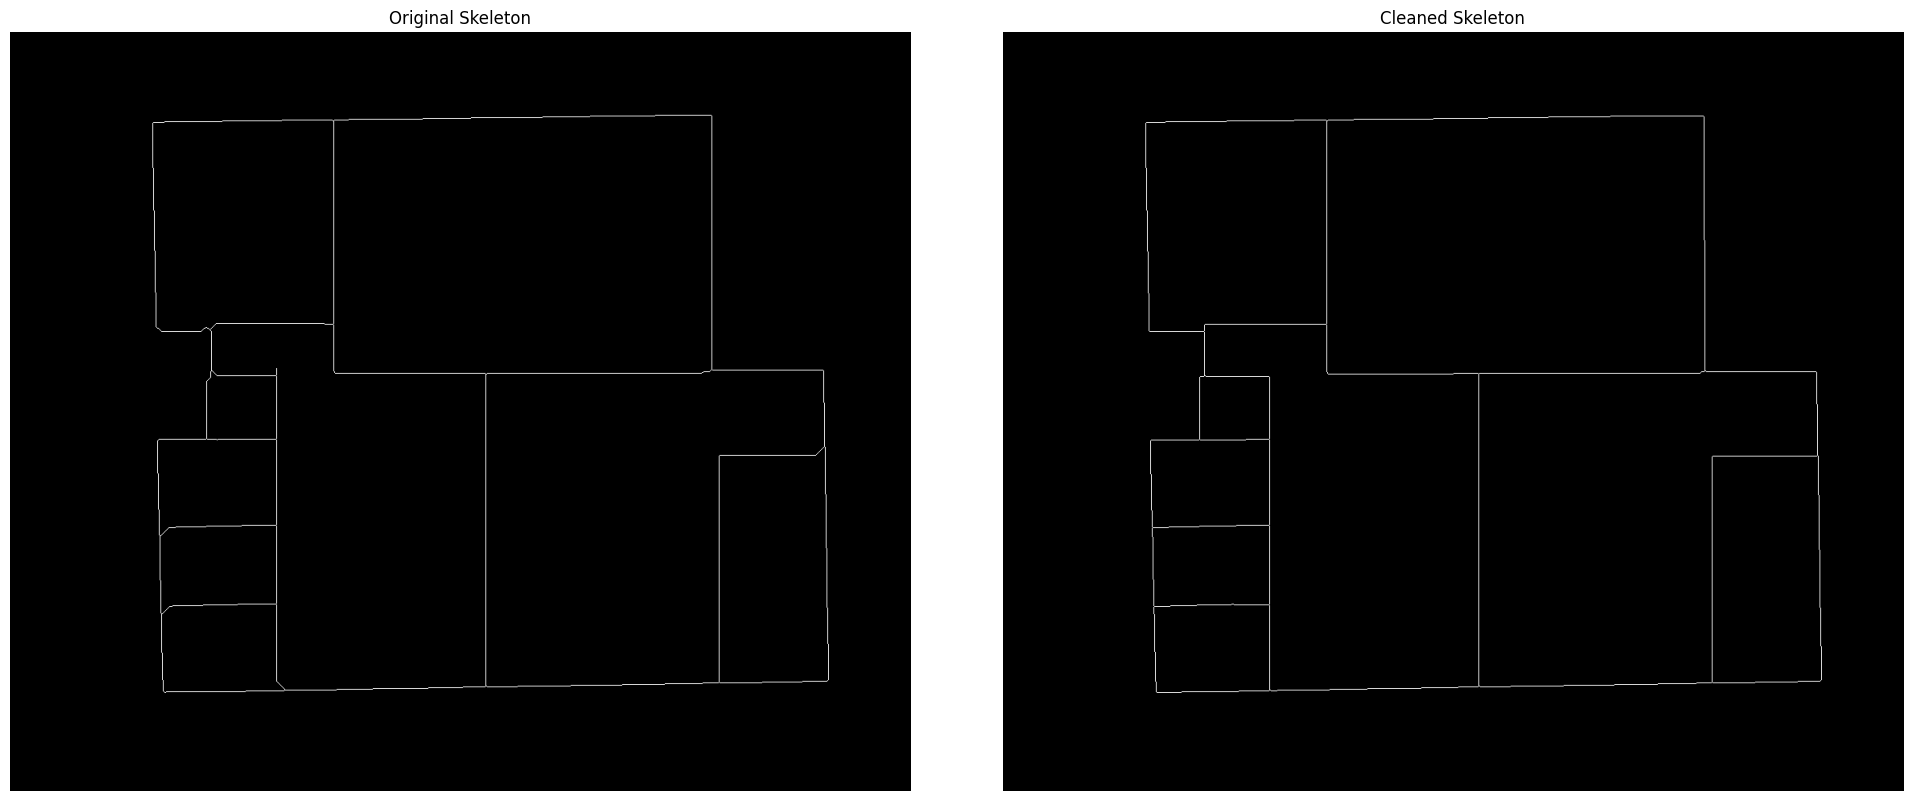

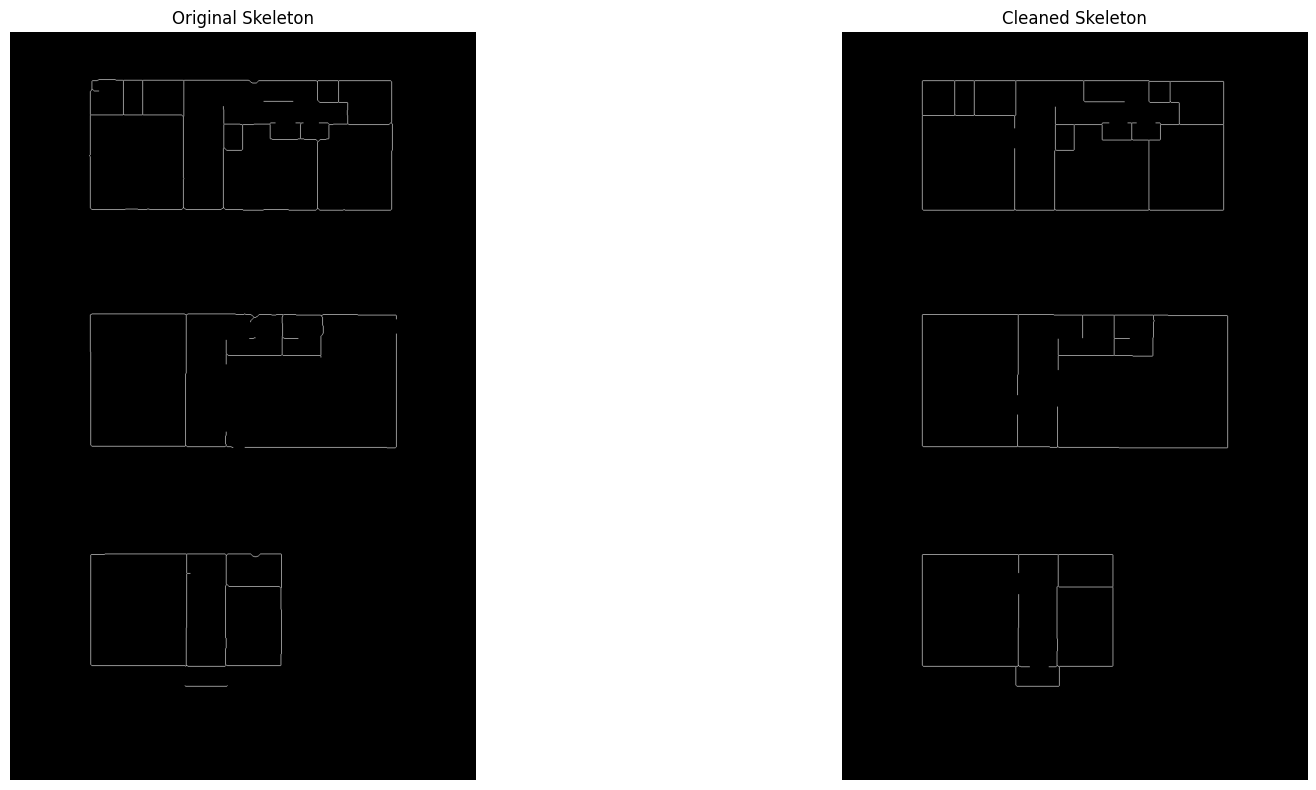

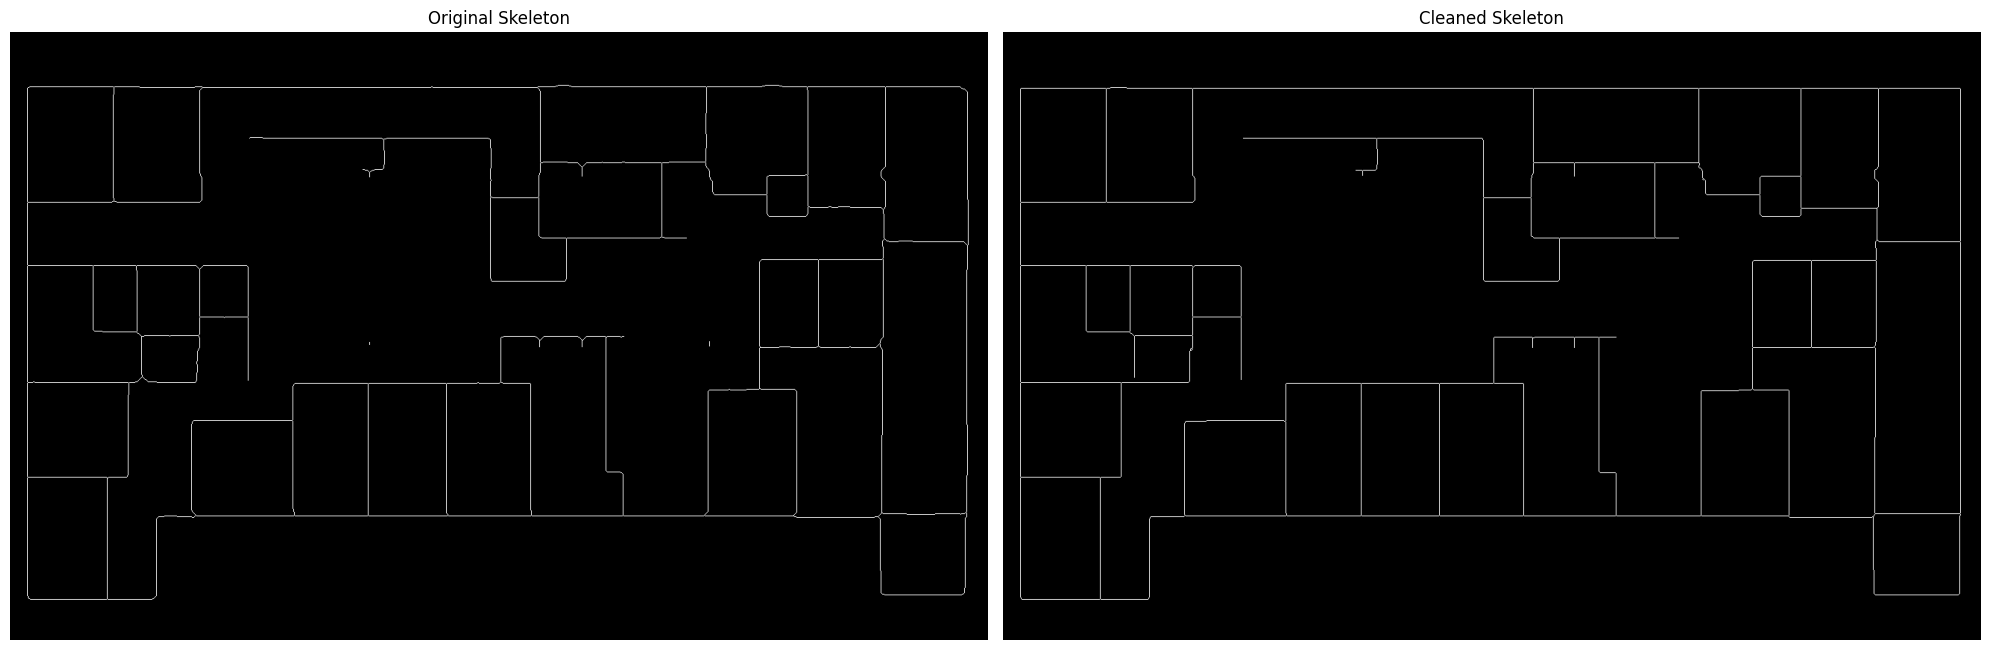

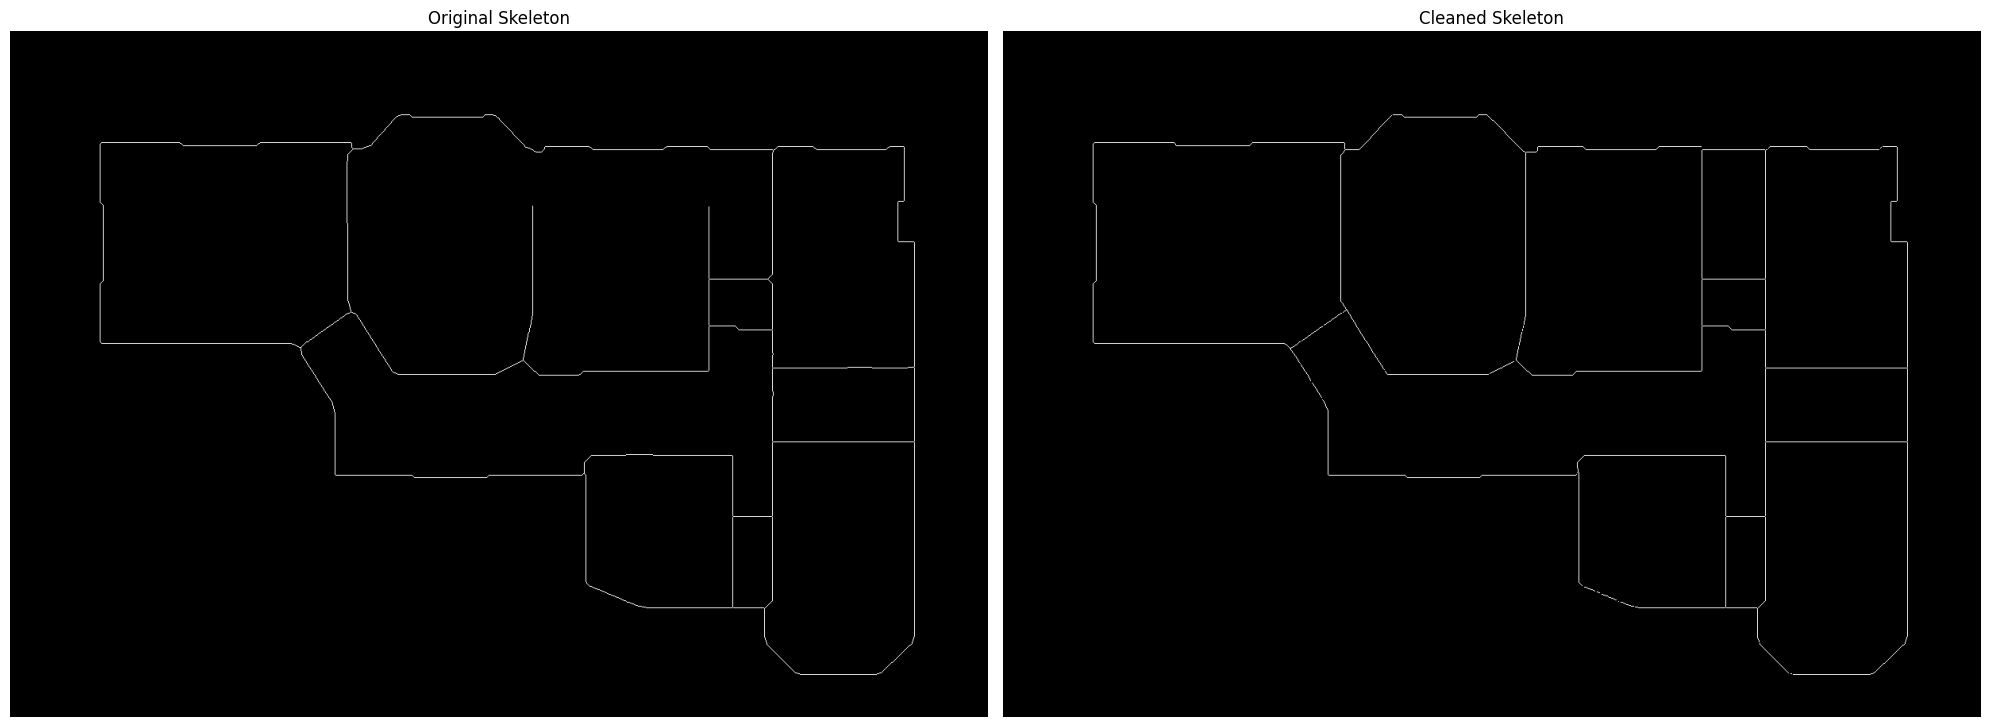

In [5]:
await batch_clean_skeletons()

⚠️ On one instance it completely hallucinated

We can filter out those cases based on metric such as the IOU with the input skeleton, though.

## Now the same experiment but starting from the wall network (no good reuslts, it doesn't know how to skeletonize)

We ask Gemini to skeletonize the wall network directly

⚠️ This experiment fails: Gemini doesn't know how to skeletonize, see images below

In [6]:
async def skeletonize_walls(input_image_bytes: bytes, path: Path) -> Image.Image:
    agent = Agent(
        name="SkeletonizingAgent",
        model=MODEL_NAME,
        output_type=BinaryImage,
        instructions="""You are a computer vision and floorplans specialist. The input is a binary raster image representing a wall network: white pixels indicate walls,
        black is background.

    **Your task:**  
    Generate a cleaned, high-fidelity skeleton with the following properties:
    
    - **Skeletonize walls:** Extract the 1-pixel wide centerline skeleton of the wall network.
    - **Straighten lines:** Replace jagged or wavy segments with straight lines where appropriate.
    - **Align and snap:** Align walls to be parallel or perpendicular where possible, and snap angles to standard values (e.g., 90°, 45°).
    - **Maintain connectivity:** Ensure all original connections between segments are preserved, even if you remove or adjust parts.
    - **Suppress forks:** Remove any Y-shaped junctions, replacing them with T-junctions to simplify the network.
    - **Remove artifacts:** Eliminate small bumps, spurs, or noise, replacing them with straight segments or removing them entirely when appropriate.
    - **Preserve 1-pixel width:** The output skeleton must remain a single-pixel wide everywhere.
    - **Do not invent or remove walls:** Only modify the geometry of the existing network; do not add or delete any wall segments.
    - **Enhance junction clarity:** Make all junctions clear and unambiguous to facilitate downstream detection.
    - **Avoid arcs and curves:** All wall segments should be straight lines; do not introduce any curved segments.

    **Output:**  
    A binary raster image of a clean skeleton, with all the above properties enforced. The output should closely match the topology and layout of the input,
    but with improved geometric regularity and clarity.""",
    )
    image_bytes = await agent.run(
        user_prompt=[BinaryImage(data=input_image_bytes, media_type="image/png")]
    )
    return Image.open(io.BytesIO(image_bytes.output.data)).convert("L")


def skeletonize_gemini_img(gemini_img: Image.Image) -> Image.Image:
    arr = np.array(gemini_img, dtype=np.uint8)
    # threshold it to make it binary, using Otsu's method
    _, gemini_img = cv2.threshold(arr, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skeleton = skeletonize(gemini_img, method="lee")

    skeleton_img = (skeleton * 255).astype(np.uint8)
    img = Image.fromarray(skeleton_img)
    return img

In [7]:
def create_side_by_side_viz_from_walls(
    original_walls: Path,
    gemini_img: Image.Image,
    gemini_img_skeletonized: Image.Image,
    our_skeleton: Image.Image,
) -> None:
    _, axes = plt.subplots(1, 4, figsize=(20, 6))
    original_img = Image.open(original_walls).convert("L")
    gemini_skeleton_image = gemini_img_skeletonized.convert("L")
    our_skeleton_img = our_skeleton.convert("L")
    if gemini_skeleton_image.size != original_img.size:
        gemini_skeleton_image = gemini_skeleton_image.resize(
            original_img.size, resample=Image.NEAREST
        )
    if our_skeleton_img.size != original_img.size:
        our_skeleton_img = our_skeleton_img.resize(original_img.size, resample=Image.NEAREST)
    if gemini_img.size != original_img.size:
        gemini_img = gemini_img.resize(original_img.size, resample=Image.NEAREST)

    axes[0].imshow(original_img, cmap="gray")
    axes[0].set_title("Original Walls")
    axes[0].axis("off")
    axes[1].imshow(gemini_img, cmap="gray")
    axes[1].set_title("Gemini Skeleton")
    axes[1].axis("off")
    axes[2].imshow(gemini_skeleton_image, cmap="gray")
    axes[2].set_title("Gemini skeleton then skeletonized by us")
    axes[2].axis("off")
    axes[3].imshow(our_skeleton_img, cmap="gray")
    axes[3].set_title("Our skeleton (no Gemini intervention)")
    axes[3].axis("off")
    plt.tight_layout()

In [8]:
async def batch_skeletonize_walls(n_samples: int = 17):
    input_image_paths = [
        f
        for f in Path()
        .cwd()
        .glob("binary_walls_*.png")  # the debug images produced in full_walls_detection.py
        if "cleaned" not in f.stem
    ][:n_samples]
    output_image_paths = [
        (input_image_path.parent / f"{input_image_path.stem}_cleaned{input_image_path.suffix}")
        for input_image_path in input_image_paths
    ]

    tasks = []
    for input_image_path, output_image_path in zip(
        input_image_paths, output_image_paths, strict=True
    ):
        with open(input_image_path, "rb") as f:
            input_image_bytes = f.read()
        tasks.append(skeletonize_walls(input_image_bytes, output_image_path))

    gemini_skeletons = await asyncio.gather(*tasks)

    for input_image_path, gemini_skeleton in zip(input_image_paths, gemini_skeletons, strict=True):
        # let's do our skeletonizing just like in full_walls_detection.py
        walls_arr = (np.array(Image.open(input_image_path).convert("L")) > 0).astype(np.uint8)
        our_skeleton_arr = skeletonize(walls_arr, method="lee")
        our_skeleton_img = Image.fromarray((our_skeleton_arr * 255).astype(np.uint8))

        # now skeletonize the gemini output again to ensure 1-pixel width
        gemini_skeletonized = skeletonize_gemini_img(gemini_skeleton)

        create_side_by_side_viz_from_walls(
            original_walls=input_image_path,
            gemini_img=gemini_skeleton,
            gemini_img_skeletonized=gemini_skeletonized,
            our_skeleton=our_skeleton_img,
        )

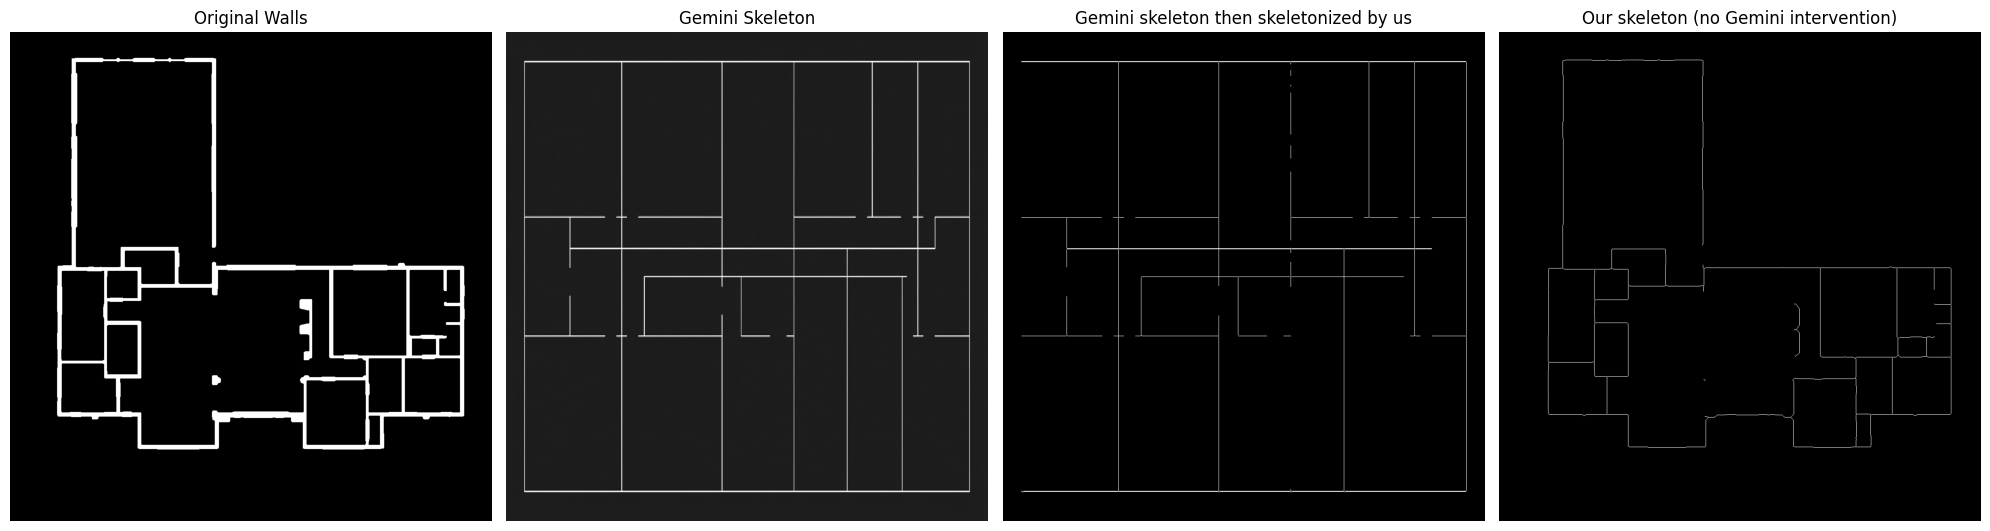

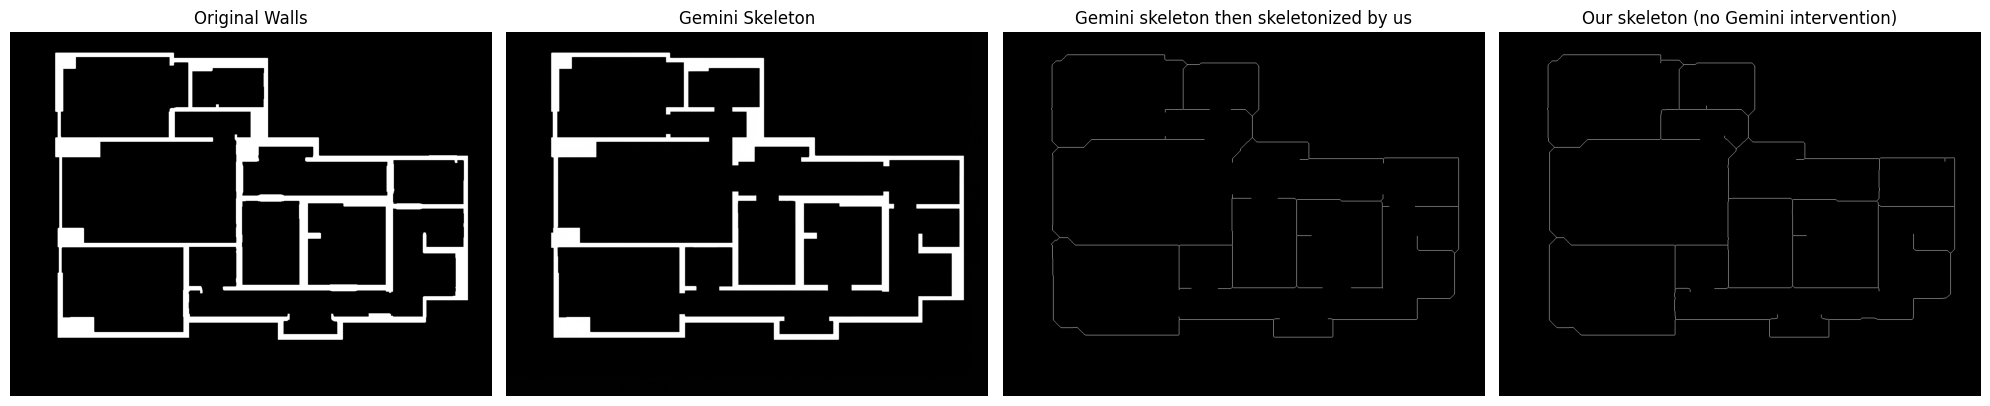

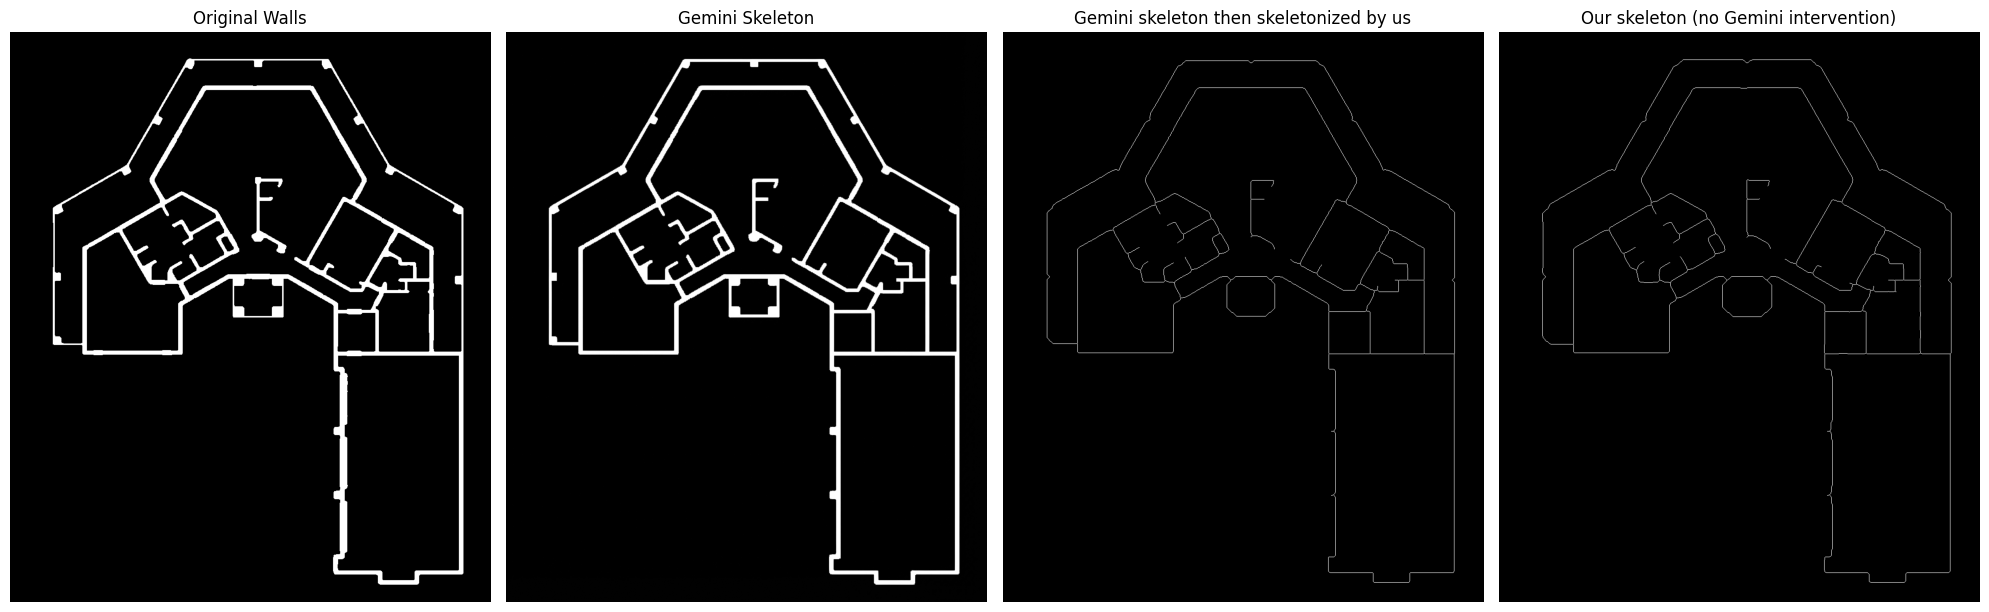

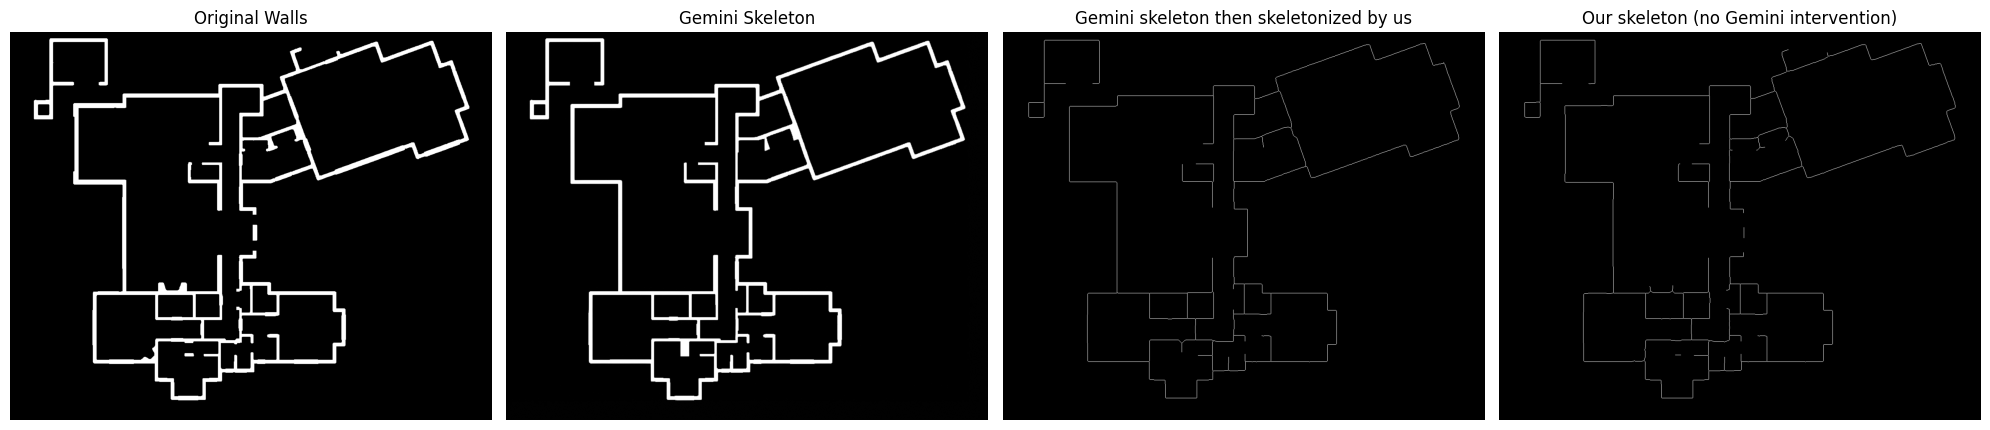

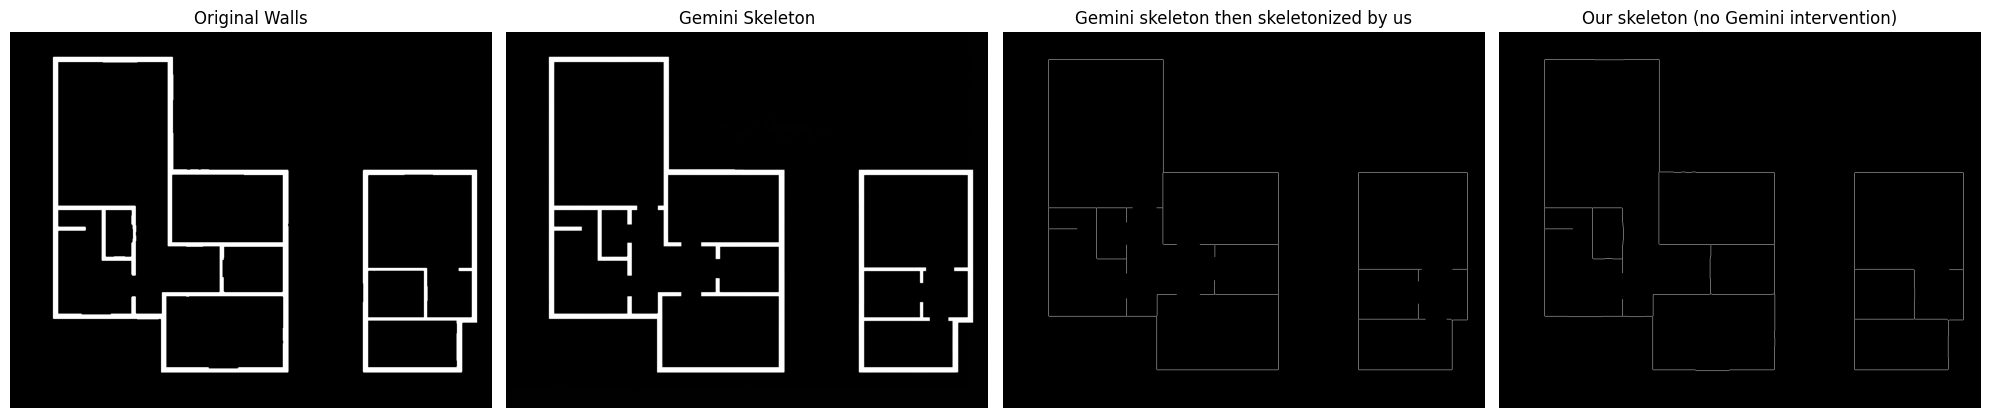

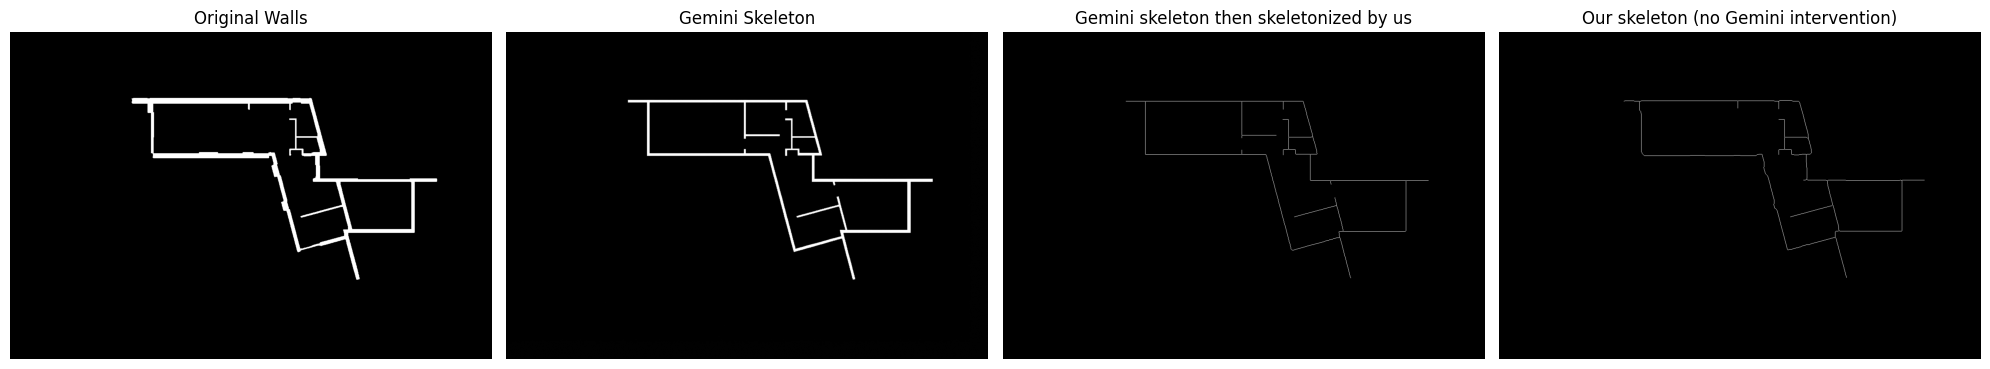

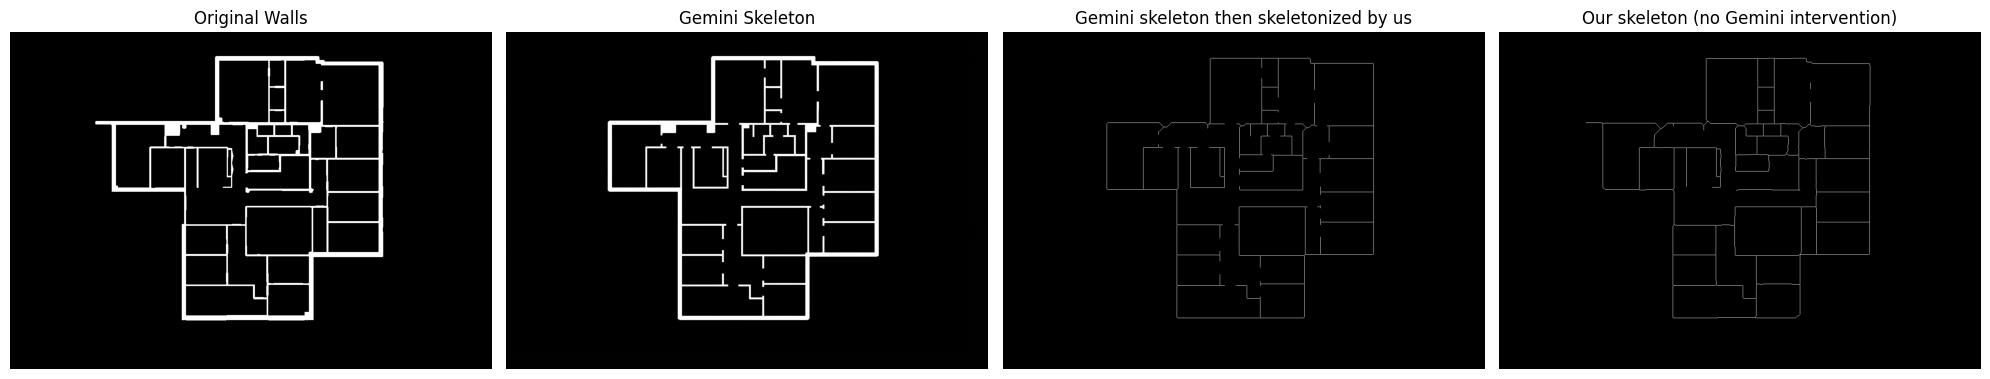

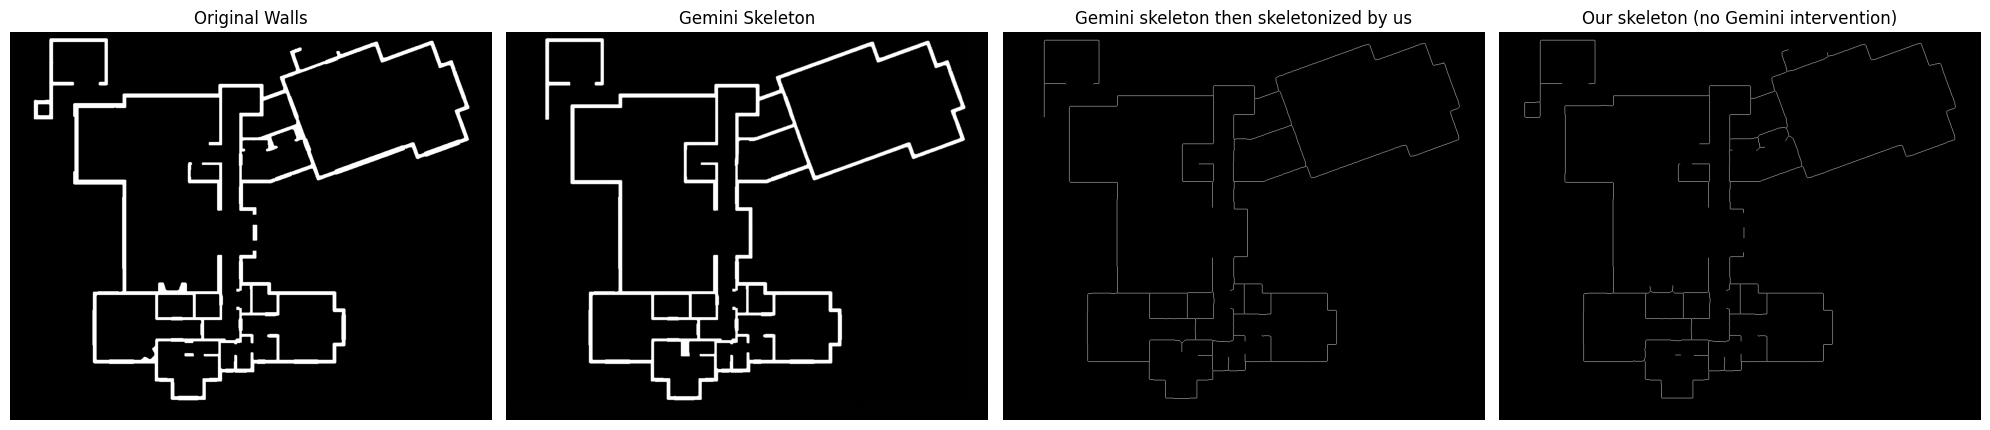

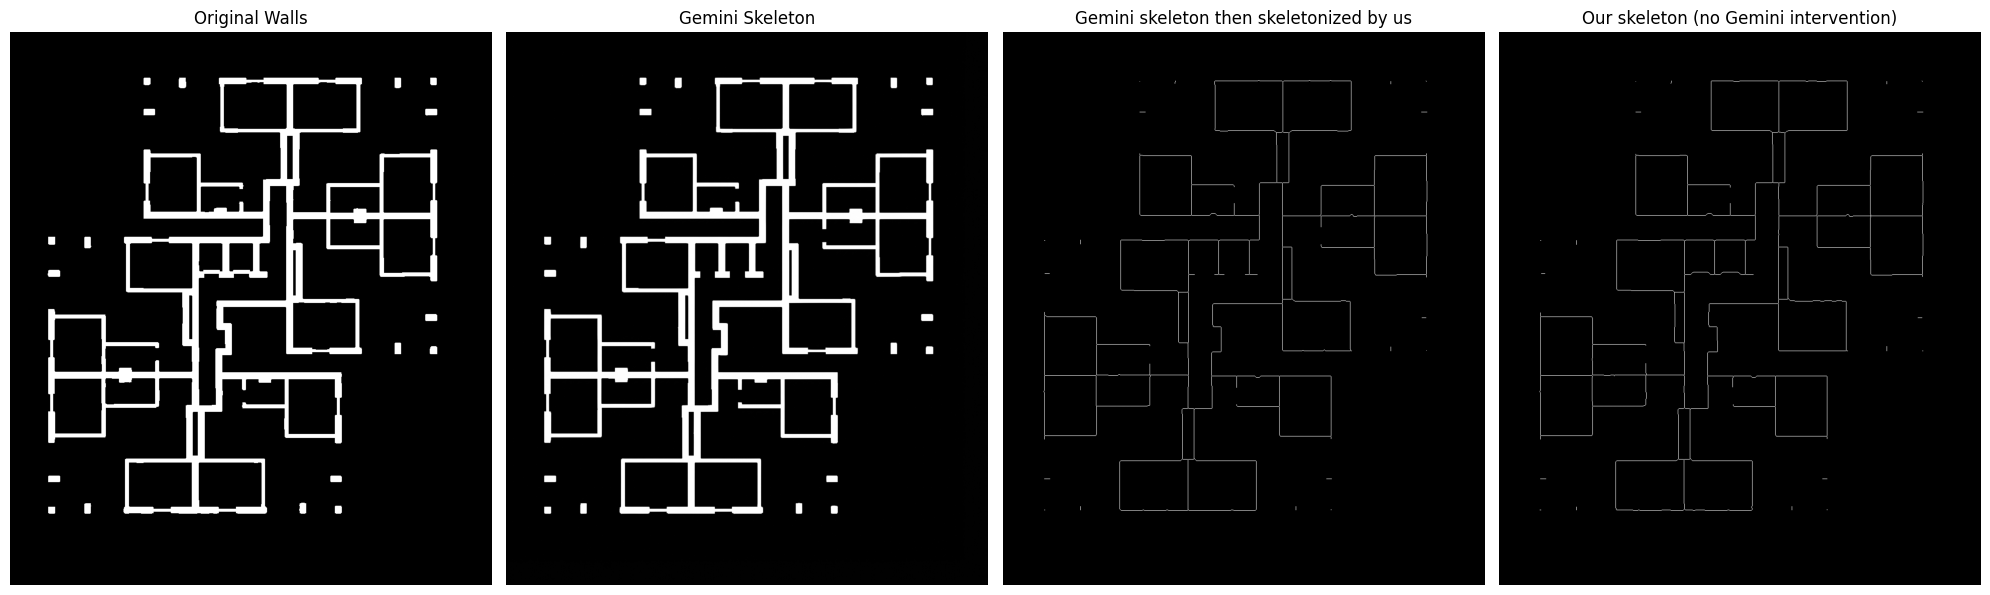

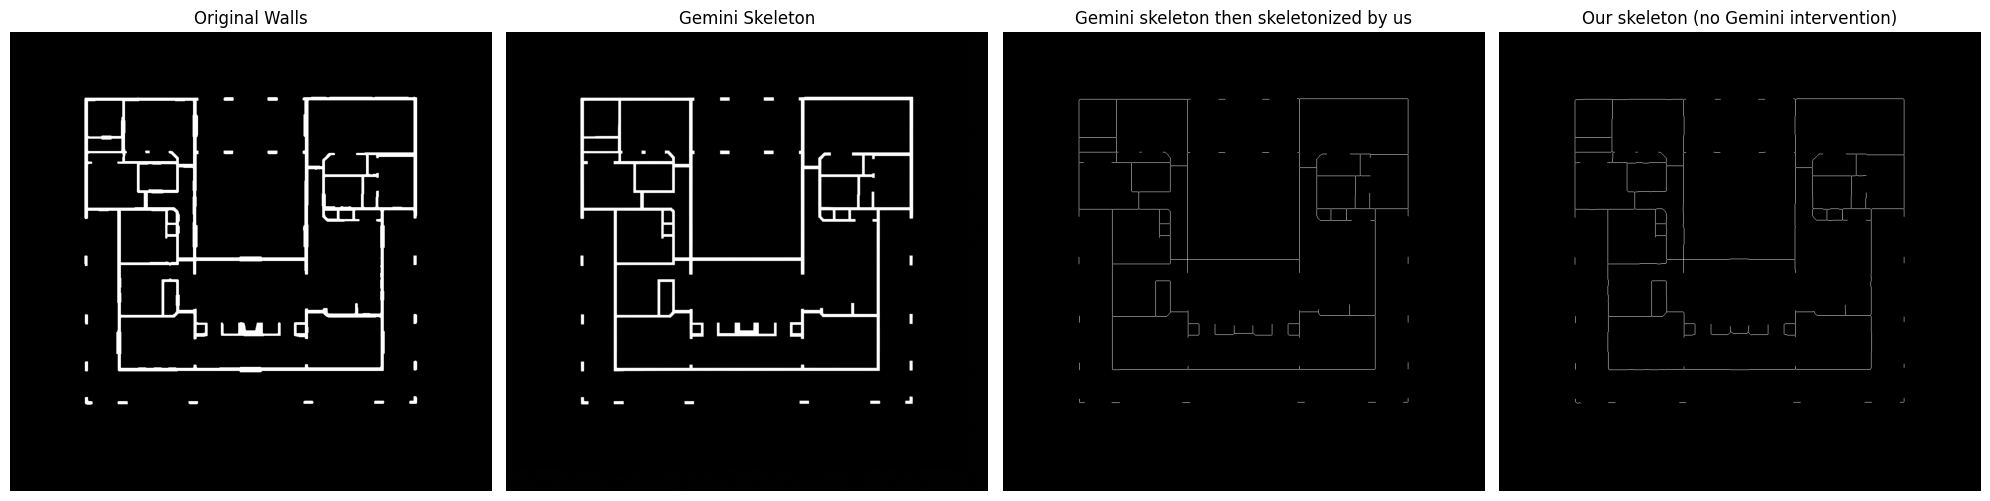

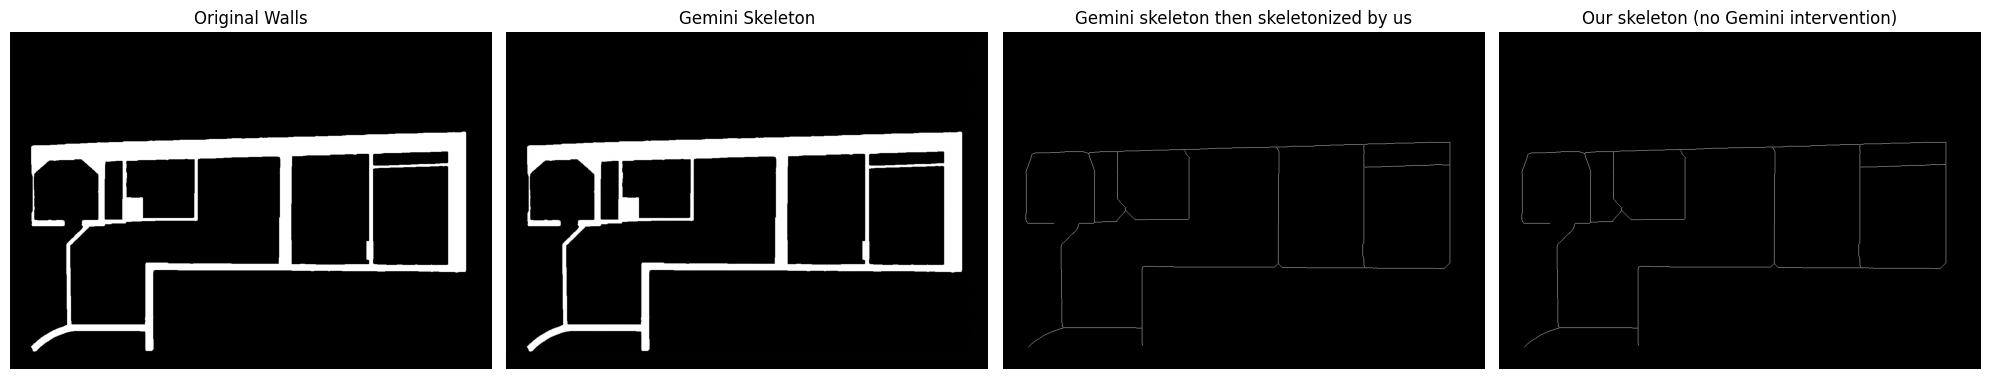

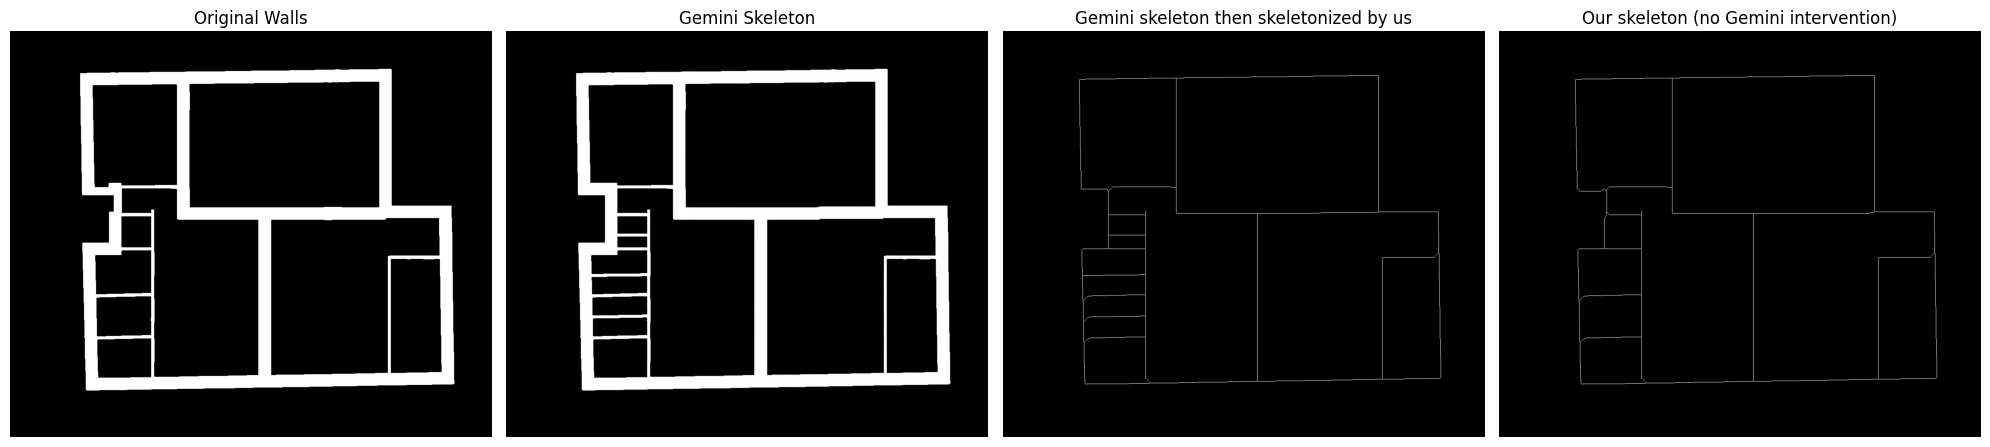

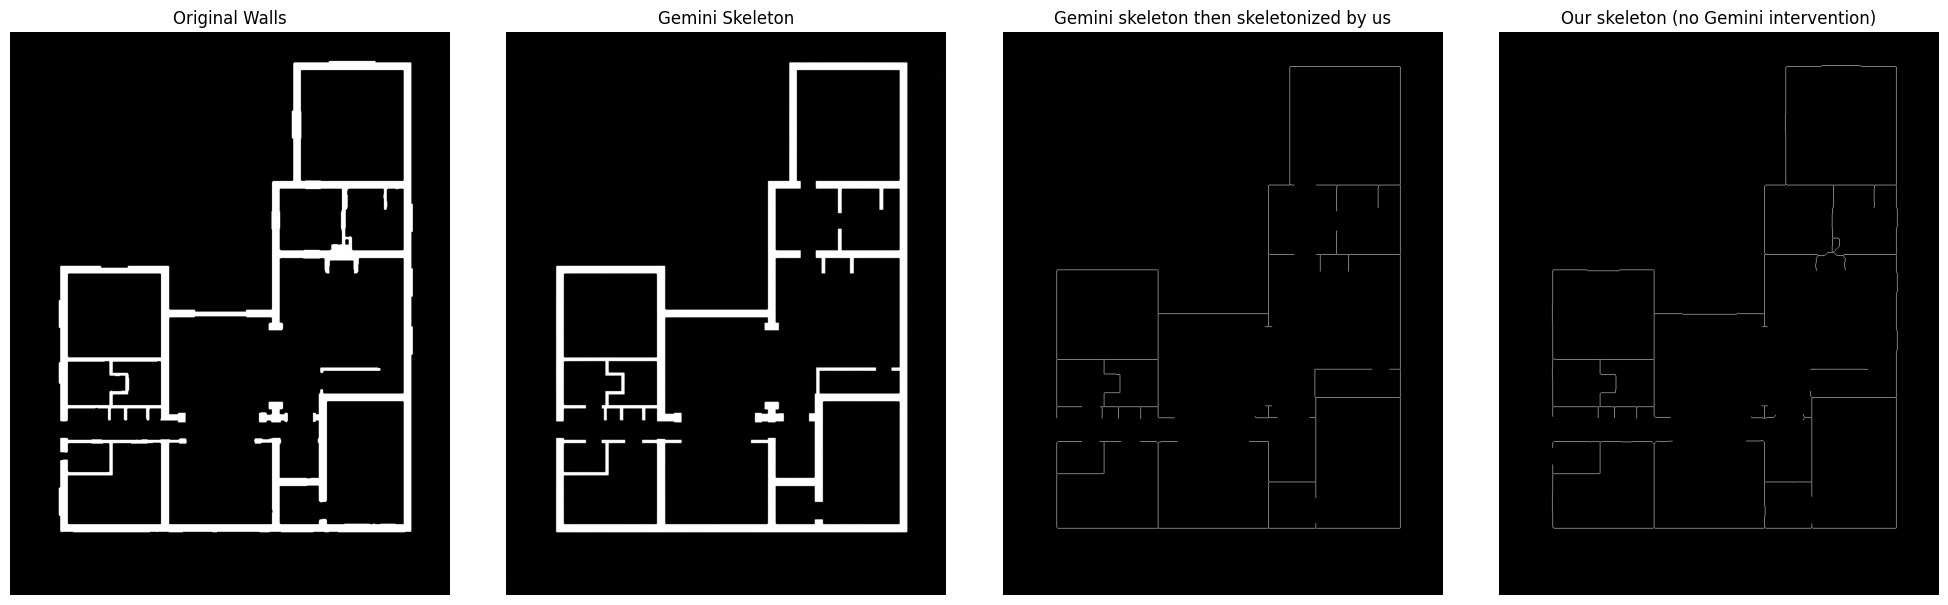

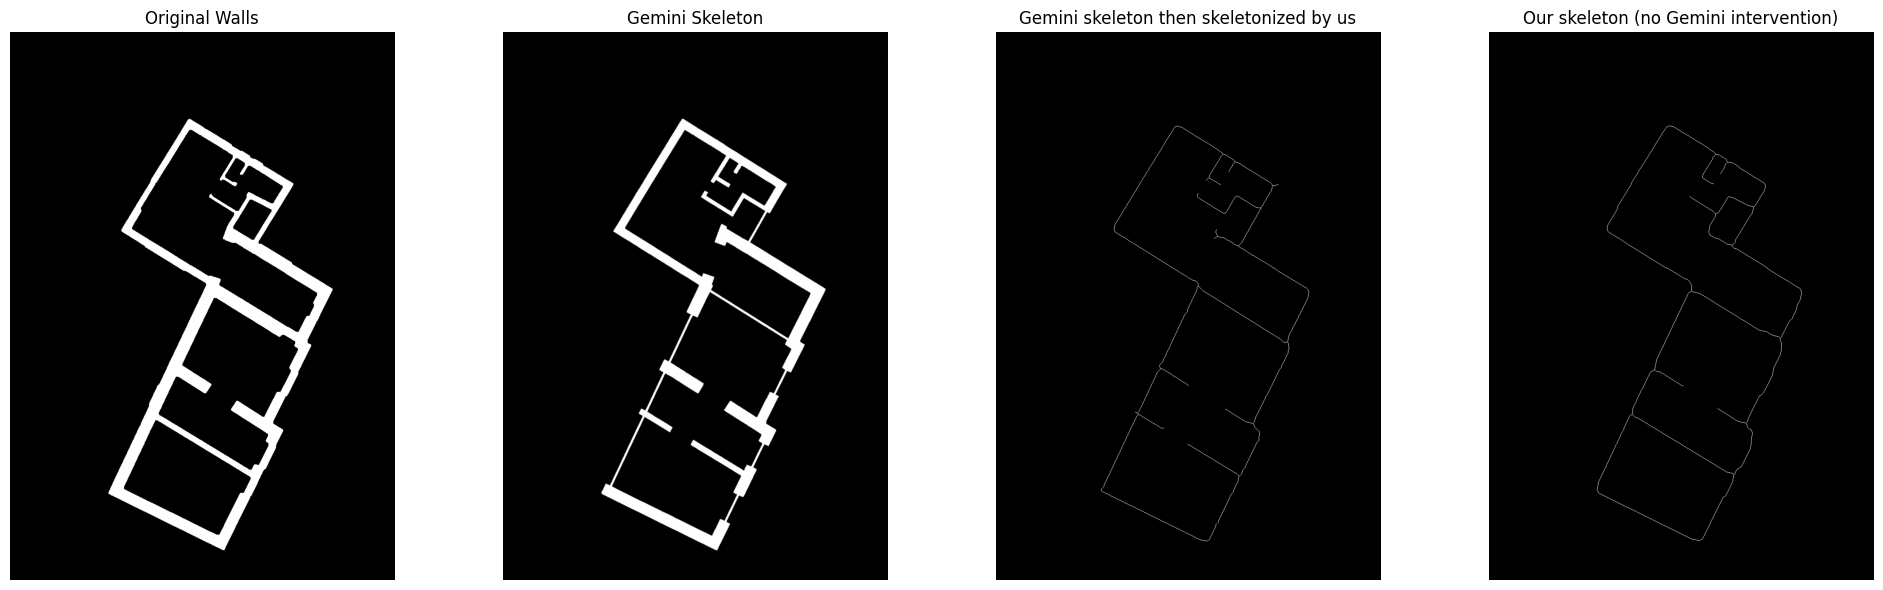

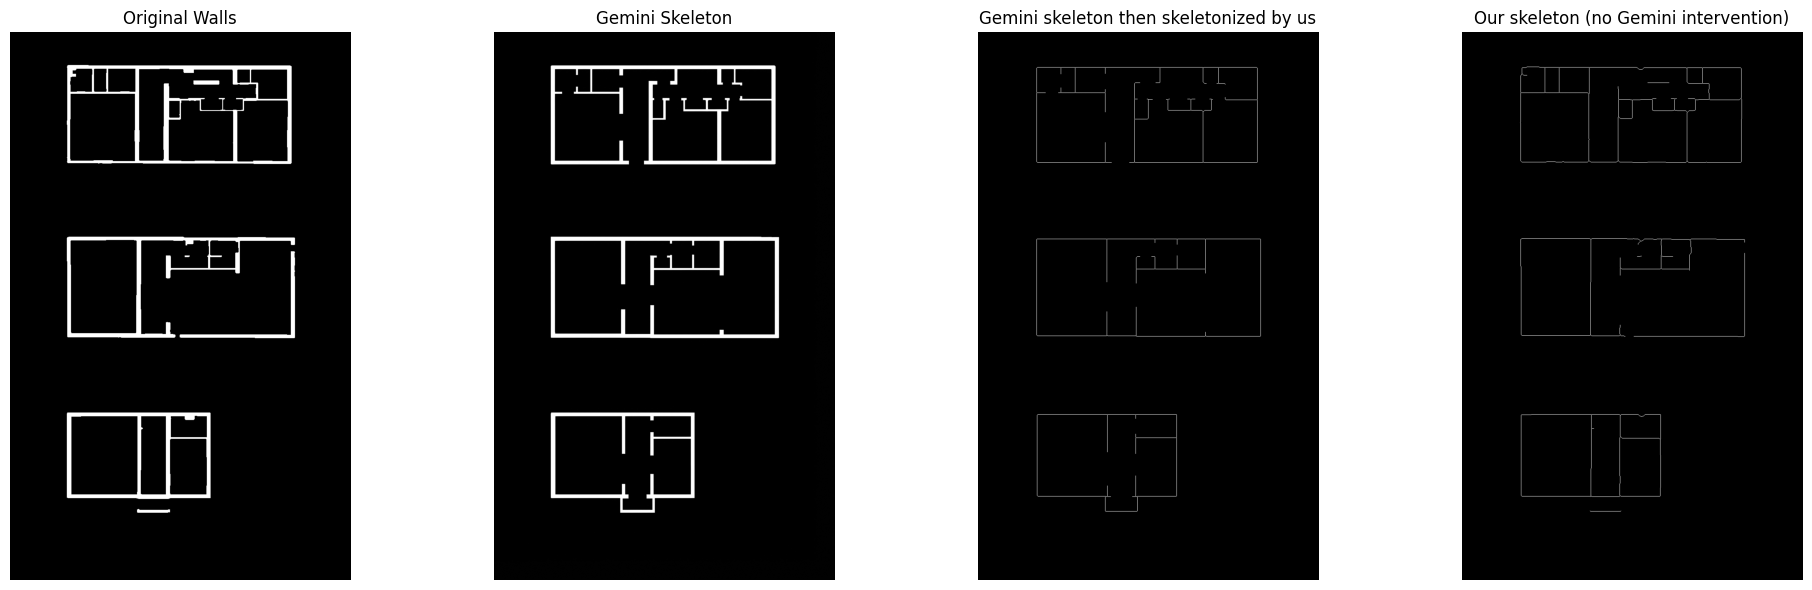

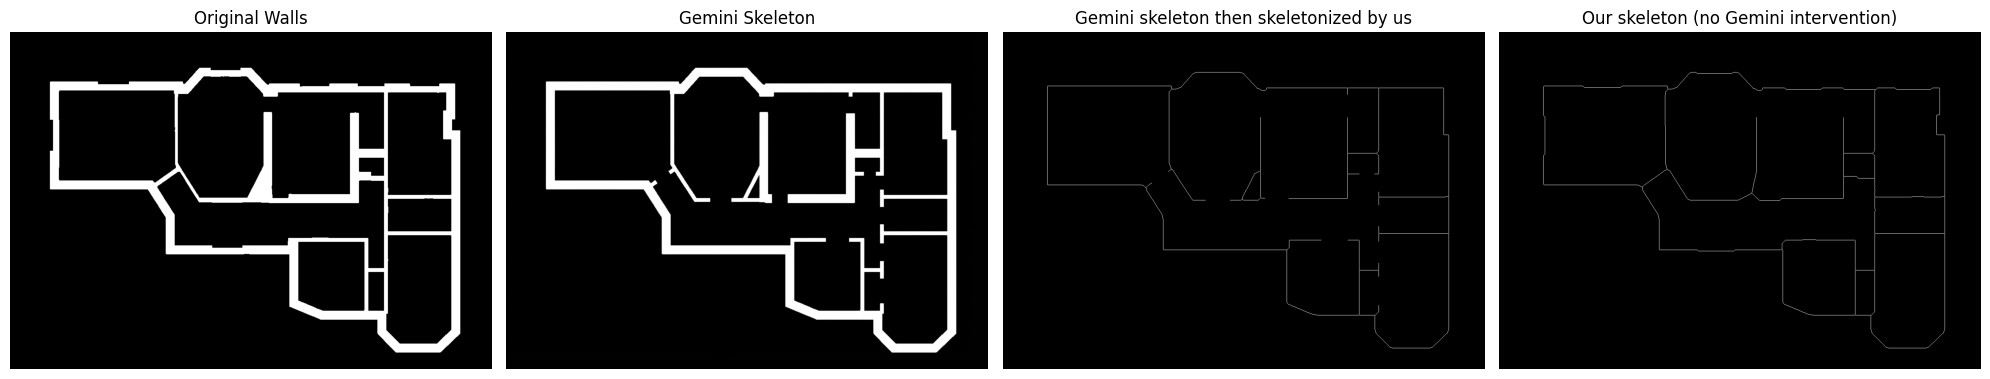

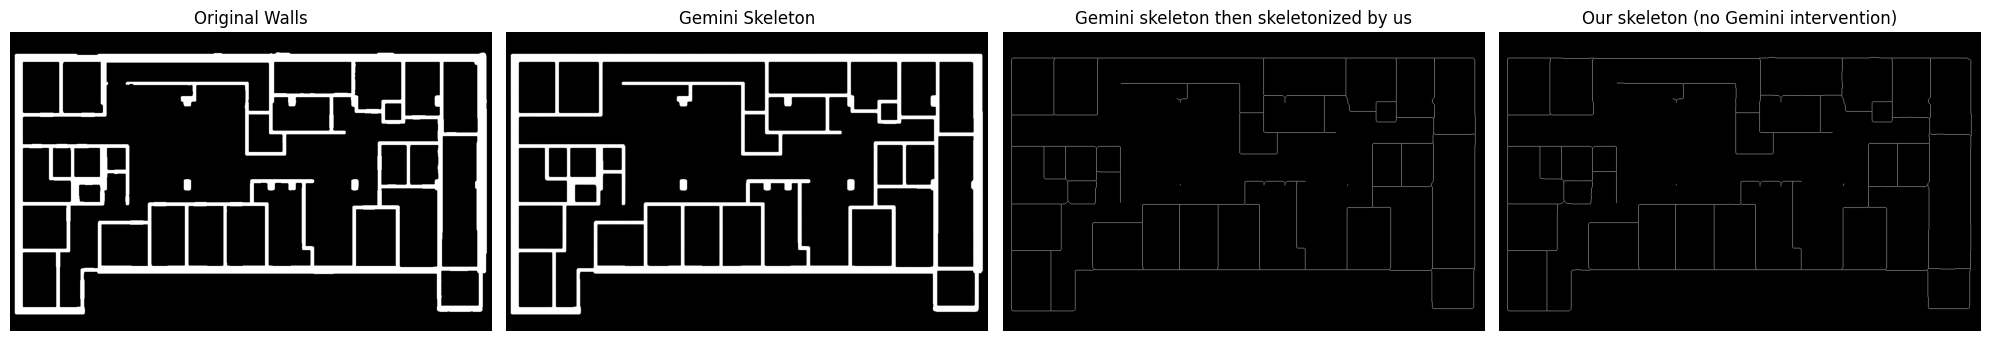

In [9]:
await batch_skeletonize_walls()